# The Final project of the Data Science Bootcamp at WBS Coding School 
## Price prediction of used Cars for the US market by using Machine Learning

Imagine you have a car, that you used for while and for whatever reasons you want to sell it. The problem is, that you have no ideas about cars and dont know at what price you want to sell it. Is the selling price you had in mind to high or maybe is it too low?<br>Sure in order to answer this question you can go to platforms for used cars and compare some prices, which is probably the most efficient way to get a ideal selling price. But is it possible to determine the ideal sales price using machine learning and with what accuracy is this possible? <br>
The examination of these questions is the subject of our final project in the Data Science Bootcamp.

## Agenda

To address these questions, our approach was as follows:
- Load a dataset that seems suitable for our purpose
- subsequent data cleaning
- Reconstruct as much missing data as possible
- Remove potential outliers that could distort the calculations of the ML model
- Transform the columns into a suitable way for the comming Machine Learning model
- Subdivision of the data set into training and test data set and creation of an ideal ML model
- Training and testing of the ML model on defined datasets
- Optimisation of the ML model
- Subsequent implementation of the model in a usable WebApp

In [80]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor 
import requests
import pickle
from catboost import Pool
from catboost import CatBoostRegressor
from sklearn import metrics

## Loading dataset
The following dataset was found [here](https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data).

In [2]:
dataset= pd.read_csv('vehicles.csv')

## Data Cleaning
To have a first insight into the dataset, we list all columns to see which of them we need. 

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

We considered the following columns as non-related: 
- ***'url'*** 
- ***'regio'*** 
- ***'region_url'*** 
- ***'VIN'***
- ***'image_url'*** 
- ***'county'***  
- ***'state'***  
- ***'lat'*** 
- ***'long'***
- ***'description*** <br>
Even though we considered the describtion as nonrelated, the description probably a lot of useful information. But it is a long procces to exctract the neeeded information from it, so we consider using it as a feature later. 

In [4]:
non_related_columns = ['id', 'url' , 'region', 'region_url', 'VIN', 'image_url', 'county', 'state', 'lat', 'long', 'description']
data = dataset.drop(columns= non_related_columns)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   cylinders     249202 non-null  object 
 6   fuel          423867 non-null  object 
 7   odometer      422480 non-null  float64
 8   title_status  418638 non-null  object 
 9   transmission  424324 non-null  object 
 10  drive         296313 non-null  object 
 11  size          120519 non-null  object 
 12  type          334022 non-null  object 
 13  paint_color   296677 non-null  object 
 14  posting_date  426812 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 48.9+ MB


## Data quality
### Missing values

First we tackle the issue of data quality. To check the data quality, we first check how many "NaN" exist in the whole dataset...

In [5]:
data.isna().sum().sum()

1054178

... than we check which columns are affected and to what extent theyn are affected.

In [6]:
data.isna().sum()

price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
drive           130567
size            306361
type             92858
paint_color     130203
posting_date        68
dtype: int64

The column ***'condition'*** has a lot of missing values. In order to see, if these values are somehow restorable, we have take a look at all the unique values, this columns contains. 

In [7]:
data['condition'].unique()

array([nan, 'good', 'excellent', 'fair', 'like new', 'new', 'salvage'],
      dtype=object)

Unfortunately it seems, that there is no sign or possibility, that we can restore missing values, so we drop them temporarily.

In [8]:
#temprary drop tha non value in condition
temp = data.copy()
temp = temp.dropna(subset=['condition'])

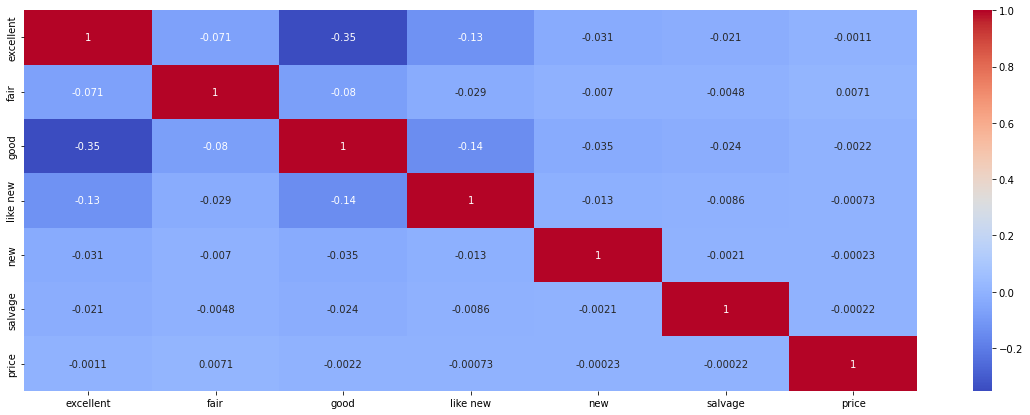

In [9]:
#calculate correlation matris with onehot encoder
corr_matrix = pd.get_dummies(data["condition"]).assign(price = data.price).corr()

fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, annot_kws={'size':10}, )
plt.show()

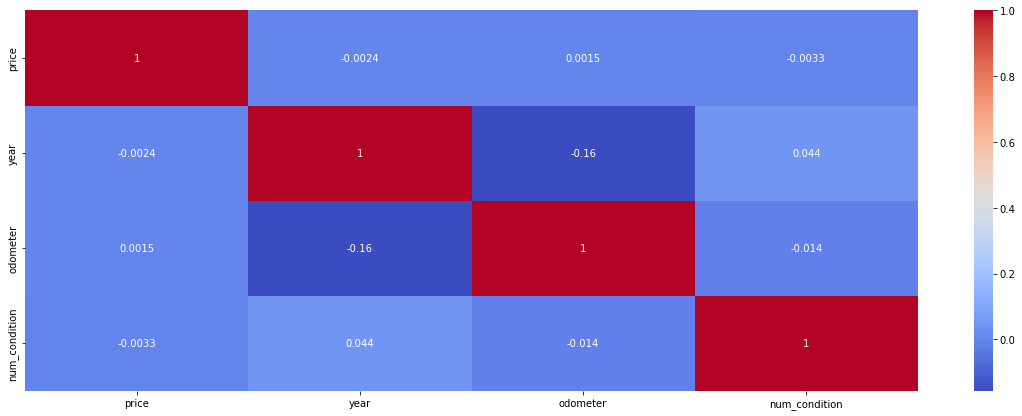

In [10]:
#make ordinary list for condition
con_category= ['salvage', 'fair', 'good', 'excellent', 'like new', 'new']
#make a columntransformer
ct= ColumnTransformer([("ordinal", OrdinalEncoder(categories=[con_category]),['condition'])])
# add new column num_condition using the our tranformer
temp['num_condition'] = [x[0] for x in ct.fit_transform(temp)]

fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(temp.corr(), cmap='coolwarm', annot=True, annot_kws={'size':10}, )
plt.show()

Since there is no posssibility yet to restore the missing values in the columns ***'condition'***, ***'year'*** and ***'odometer'***, we drop them.

In [11]:
data_v1 = data.dropna(subset =['condition', 'year', 'odometer'])
data_v1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250851 entries, 27 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         250851 non-null  int64  
 1   year          250851 non-null  float64
 2   manufacturer  240069 non-null  object 
 3   model         248581 non-null  object 
 4   condition     250851 non-null  object 
 5   cylinders     180274 non-null  object 
 6   fuel          250835 non-null  object 
 7   odometer      250851 non-null  float64
 8   title_status  245368 non-null  object 
 9   transmission  250817 non-null  object 
 10  drive         190003 non-null  object 
 11  size          96352 non-null   object 
 12  type          218331 non-null  object 
 13  paint_color   199763 non-null  object 
 14  posting_date  250851 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 30.6+ MB


In order to predict the car price for each car manufacturer and model properly we need at least a minimum of data entries for each manufacturer. 

In [12]:
data_v1['manufacturer'].value_counts()

ford               37563
chevrolet          32208
toyota             20460
honda              12835
nissan             11015
jeep               10442
gmc                 9390
bmw                 9155
ram                 8144
dodge               7590
mercedes-benz       6560
volkswagen          6232
hyundai             5997
subaru              5542
lexus               5280
audi                5217
kia                 4912
cadillac            4489
acura               4477
chrysler            3653
buick               3640
mazda               3591
infiniti            3552
lincoln             3049
volvo               2475
mitsubishi          2327
mini                1598
jaguar              1568
pontiac             1484
rover               1181
mercury              839
alfa-romeo           747
porsche              733
saturn               700
tesla                668
fiat                 566
harley-davidson       84
datsun                41
ferrari               41
aston-martin          12


Having this overview of all data entries for every manufacturer, we decide that every manufacturer to have a minimum of at least 700 data entries. As a result of that we drop the following manufacturers:
- Tesla
- Fiat
- Harley-Davidson
- Ferrari
- Datson
- Aston-Martin
- Land Rover
- Morgan
- Datsun

In [13]:
drop_manufacturer = ['tesla', 'fiat','harley-davidson', 'ferrari', 'datson', 'aston-martin', 'land rover', 'morgan', 'datsun']

In [14]:
data_v2 = data_v1[~data_v1['manufacturer'].isin(drop_manufacturer)]

In [15]:
data_v2['manufacturer'].value_counts()

ford             37563
chevrolet        32208
toyota           20460
honda            12835
nissan           11015
jeep             10442
gmc               9390
bmw               9155
ram               8144
dodge             7590
mercedes-benz     6560
volkswagen        6232
hyundai           5997
subaru            5542
lexus             5280
audi              5217
kia               4912
cadillac          4489
acura             4477
chrysler          3653
buick             3640
mazda             3591
infiniti          3552
lincoln           3049
volvo             2475
mitsubishi        2327
mini              1598
jaguar            1568
pontiac           1484
rover             1181
mercury            839
alfa-romeo         747
porsche            733
saturn             700
Name: manufacturer, dtype: int64

In [16]:
data_v2.isna().sum()

price                0
year                 0
manufacturer     10782
model             2253
condition            0
cylinders        69611
fuel                16
odometer             0
title_status      5462
transmission        34
drive            60567
size            153376
type             32377
paint_color      50733
posting_date         0
dtype: int64

Our next step is to restore the missing values from ***'cylinders'***. In order to restore them we created a function that fills the missing values of the column ***'cylinders'*** based on the car manufacturer and car model. 
i start to fill mising values from cylenders, i will serach for the same manufactores and model for that row, and if i find that i fill the missed value

In [17]:
def find_number_of_cylinedrs(manufacturer, model):
    result = data_v2.loc[lambda df_ : ((df_['manufacturer'] == manufacturer) & (df_['model'] == model) & (~df_['cylinders'].isna()))]
    if result.shape[0] == 0:
        return np.nan
    return result.iloc[0,]['cylinders']

In [18]:


data_v3=(
    data_v2
        .assign(re_cylinders = np.where(
            data_v2['cylinders'].isna(),
            find_number_of_cylinedrs(data_v2['manufacturer'],data_v2['model']),
            data_v2['cylinders']
        ))
)

In [19]:
data_v3.isna().sum()

price                0
year                 0
manufacturer     10782
model             2253
condition            0
cylinders        69611
fuel                16
odometer             0
title_status      5462
transmission        34
drive            60567
size            153376
type             32377
paint_color      50733
posting_date         0
re_cylinders         0
dtype: int64

Now we use this iterate this process for the columns ***'fuel'***, ***'transmission'***, ***'drive'***, ***'size'***, ***'type'*** 

In [20]:
def find_fuel(manufacturer, model):
    result = data_v3.loc[lambda df_ : ((df_['manufacturer'] == manufacturer) & (df_['model'] == model) & (~df_['fuel'].isna()))]
    if result.shape[0] == 0:
        return np.nan
    return result.iloc[0,]['fuel']


def find_transmission(manufacturer, model):
    result = data_v3.loc[lambda df_ : ((df_['manufacturer'] == manufacturer) & (df_['model'] == model) & (~df_['transmission'].isna()))]
    if result.shape[0] == 0:
        return np.nan
    return result.iloc[0,]['transmission']


def find_drive(manufacturer, model):
    result = data_v3.loc[lambda df_ : ((df_['manufacturer'] == manufacturer) & (df_['model'] == model) & (~df_['drive'].isna()))]
    if result.shape[0] == 0:
        return np.nan
    return result.iloc[0,]['drive']

def find_size(manufacturer, model):
    result = data_v3.loc[lambda df_ : ((df_['manufacturer'] == manufacturer) & (df_['model'] == model) & (~df_['size'].isna()))]
    if result.shape[0] == 0:
        return np.nan
    return result.iloc[0,]['size']

def find_type(manufacturer, model):
    result = data_v3.loc[lambda df_ : ((df_['manufacturer'] == manufacturer) & (df_['model'] == model) & (~df_['type'].isna()))]
    if result.shape[0] == 0:
        return np.nan
    return result.iloc[0,]['type']

In [21]:
data_v4=(
    data_v3
        .assign(re_fuel = np.where(
            data_v3['fuel'].isna(),
            find_fuel(data_v3['manufacturer'],data_v3['model']),
            data_v3['fuel']
        ))
        .assign(re_transmission = np.where(
            data_v3['transmission'].isna(),
            find_transmission(data_v3['manufacturer'],data_v3['model']),
            data_v3['transmission']
        ))
        .assign(re_drive = np.where(
            data_v3['drive'].isna(),
            find_drive(data_v3['manufacturer'],data_v3['model']),
            data_v3['drive']
        ))
        .assign(re_size = np.where(
            data_v3['size'].isna(),
            find_size(data_v3['manufacturer'],data_v3['model']),
            data_v3['size']
        ))
        .assign(re_type = np.where(
            data_v3['type'].isna(),
            find_type(data_v3['manufacturer'],data_v3['model']),
            data_v3['type']
        ))
)

In [22]:
data_v4.isna().sum()

price                   0
year                    0
manufacturer        10782
model                2253
condition               0
cylinders           69611
fuel                   16
odometer                0
title_status         5462
transmission           34
drive               60567
size               153376
type                32377
paint_color         50733
posting_date            0
re_cylinders            0
re_fuel                 0
re_transmission         0
re_drive                0
re_size                 0
re_type                 0
dtype: int64

After that we restore the missing values of the ***'manufacturer'*** column, by using the ***'model'*** . Unfortunately we can't restore the missing values of the ***'model'*** by going the other way around, so we have to drop them.

In [23]:
def find_manufacturer(model, cylinders, fuel, transmission, type):
    result = data_v4.loc[lambda df_ : ((df_['model'] == model) & (df_['re_cylinders'] == cylinders) &(df_['re_fuel'] == fuel) &
                                       (df_['re_transmission'] == transmission)&(df_['re_type'] == type) &
                                       (~df_['manufacturer'].isna()))]
    if result.shape[0] == 0:
        return np.nan
    return result.iloc[0,]['manufacturer']

In [24]:
data_v5 =(
    data_v4
        .assign(re_manufacturer = np.where(
            data_v4['manufacturer'].isna(),
            find_manufacturer(data_v4['model'],data_v4['re_cylinders'], data_v4['re_fuel'], data_v4['re_transmission'], data_v4['re_type']),
            data_v4['manufacturer']
        ))
)

In [25]:
data_v5.columns

Index(['price', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'posting_date', 're_cylinders', 're_fuel',
       're_transmission', 're_drive', 're_size', 're_type', 're_manufacturer'],
      dtype='object')

In [26]:
data_v5.dropna(subset= ['model', 'title_status'], inplace=True)
columns= ['price', 'year', 're_manufacturer', 'model', 'condition', 're_cylinders', 're_fuel', 'odometer', 'title_status', 're_transmission', 're_drive', 're_size', 're_type', 'posting_date' ,'paint_color']
data_v6 = data_v5[columns]
data_v6.columns = data_v6.columns.str.replace('re_', '')

In [27]:
data_v6.isna().sum()

price               0
year                0
manufacturer        0
model               0
condition           0
cylinders           0
fuel                0
odometer            0
title_status        0
transmission        0
drive               0
size                0
type                0
posting_date        0
paint_color     44602
dtype: int64

In [28]:
data_v6.shape

(241719, 15)

We also can't restore the missing values of the column, since there is no way to guess the paintwork of the car right. But as We fill the missing values of the ***paint_color*** since have a massive influence on the price of used cars. But as a matter of fact, the colour of the car can play an important role in the purchase decision. However, when it comes to deciding the value of a used car, car colour does not usually play a major role. And since we don't want to lose any more entries from the data set unnecessarily, we simply fill the empty rows in this column with ***none***.

In [29]:
data_v6['paint_color'].fillna(value='none', inplace=True)

/var/folders/cx/7y23ngxs2mqczcr2pxhkq24m0000gn/T/ipykernel_15474/3501033760.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_v6['paint_color'].fillna(value='none', inplace=True)


In [30]:
data_v6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241719 entries, 27 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         241719 non-null  int64  
 1   year          241719 non-null  float64
 2   manufacturer  241719 non-null  object 
 3   model         241719 non-null  object 
 4   condition     241719 non-null  object 
 5   cylinders     241719 non-null  object 
 6   fuel          241719 non-null  object 
 7   odometer      241719 non-null  float64
 8   title_status  241719 non-null  object 
 9   transmission  241719 non-null  object 
 10  drive         241719 non-null  object 
 11  size          241719 non-null  object 
 12  type          241719 non-null  object 
 13  posting_date  241719 non-null  object 
 14  paint_color   241719 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 29.5+ MB


### Dealing with data types and labelizing:

In our next, we transform the columns into a suitable format for our Machine Learning model.

First we start by extract the datetime out of column ***'posting_date'***...

In [31]:
data_v6['posting_date']

27        2021-05-04T12:31:18-0500
28        2021-05-04T12:31:08-0500
29        2021-05-04T12:31:25-0500
30        2021-05-04T10:41:31-0500
31        2021-05-03T14:02:03-0500
                    ...           
426875    2021-04-04T03:21:31-0600
426876    2021-04-04T03:21:29-0600
426877    2021-04-04T03:21:17-0600
426878    2021-04-04T03:21:11-0600
426879    2021-04-04T03:21:07-0600
Name: posting_date, Length: 241719, dtype: object

In [32]:
data_v6['posting_date']= pd.to_datetime(data_v6['posting_date'] , utc=True)

/var/folders/cx/7y23ngxs2mqczcr2pxhkq24m0000gn/T/ipykernel_15474/4100576747.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_v6['posting_date']= pd.to_datetime(data_v6['posting_date'] , utc=True)


and convert this column into integer.

In [33]:
data_v6['posting_date'] = data_v6['posting_date'].dt.year*10000 + data_v6['posting_date'].dt.month*100 + data_v6['posting_date'].dt.day


/var/folders/cx/7y23ngxs2mqczcr2pxhkq24m0000gn/T/ipykernel_15474/4181322438.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_v6['posting_date'] = data_v6['posting_date'].dt.year*10000 + data_v6['posting_date'].dt.month*100 + data_v6['posting_date'].dt.day


In [34]:
data_v6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241719 entries, 27 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         241719 non-null  int64  
 1   year          241719 non-null  float64
 2   manufacturer  241719 non-null  object 
 3   model         241719 non-null  object 
 4   condition     241719 non-null  object 
 5   cylinders     241719 non-null  object 
 6   fuel          241719 non-null  object 
 7   odometer      241719 non-null  float64
 8   title_status  241719 non-null  object 
 9   transmission  241719 non-null  object 
 10  drive         241719 non-null  object 
 11  size          241719 non-null  object 
 12  type          241719 non-null  object 
 13  posting_date  241719 non-null  int64  
 14  paint_color   241719 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 29.5+ MB


Now we transformed our ***'posting_date'*** column, our next step was to extract the amount of cylinders from the ***'cylinders'*** column.

In [35]:
def other_to_0(input):
    if input == 'other': 
        return '0 cylinders'
    return input

In [36]:
data_v6['cylinders'] = data_v6['cylinders'].apply(other_to_0)

/var/folders/cx/7y23ngxs2mqczcr2pxhkq24m0000gn/T/ipykernel_15474/2967395791.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_v6['cylinders'] = data_v6['cylinders'].apply(other_to_0)


In [37]:
data_v6['cylinders'] = data_v6['cylinders'].str.replace(r'(\d{1,2})(\s)(.*)$', r'\1', regex=True).astype('int64')

/var/folders/cx/7y23ngxs2mqczcr2pxhkq24m0000gn/T/ipykernel_15474/1092821188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_v6['cylinders'] = data_v6['cylinders'].str.replace(r'(\d{1,2})(\s)(.*)$', r'\1', regex=True).astype('int64')


Afterwards we converted the ordinal columns and train the encoders.

In order to do so we need define the ordinal columns,...

In [38]:
#ordinal encoder list
ordinal_columns= ['condition', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'paint_color']

...the ordinal categories...

In [39]:
data_v6['condition'].unique()

array(['good', 'excellent', 'fair', 'like new', 'new', 'salvage'],
      dtype=object)

In [40]:
data_v6['fuel'].unique()

array(['gas', 'other', 'diesel', 'hybrid', 'electric'], dtype=object)

In [41]:
data_v6['title_status'].unique()

array(['clean', 'rebuilt', 'lien', 'salvage', 'missing', 'parts only'],
      dtype=object)

In [42]:
data_v6['transmission'].unique()

array(['other', 'automatic', 'manual'], dtype=object)

In [43]:
data_v6['drive'].unique()

array(['rwd', '4wd', 'fwd'], dtype=object)

In [44]:
data_v6['size'].unique()

array(['full-size', 'mid-size', 'compact', 'sub-compact'], dtype=object)

In [45]:
data_v6['paint_color'].unique()

array(['white', 'blue', 'red', 'black', 'silver', 'grey', 'none', 'brown',
       'yellow', 'orange', 'green', 'custom', 'purple'], dtype=object)

In [46]:
data_v6.type.unique()

array(['pickup', 'truck', 'other', 'coupe', 'SUV', 'hatchback',
       'mini-van', 'sedan', 'offroad', 'bus', 'van', 'convertible',
       'wagon'], dtype=object)

...and the ordinal order of these categories

In [47]:

ord_condition_list = ['salvage', 'fair', 'good', 'excellent', 'like new', 'new']
ord_fuel_list = ['other', 'diesel', 'gas', 'hybrid', 'electric']
ord_title_status_list = ['salvage', 'missing', 'parts only', 'rebuilt', 'lien', 'clean']
ord_tranmission_list = ['other', 'manual', 'automatic']
ord_drive_list= ['fwd', 'rwd', '4wd']
ord_size_list = ['mid-size','full-size', 'sub-compact', 'compact']
ord_paint_color = ['white', 'blue', 'red', 'black', 'silver', 'grey', 'none', 'brown','yellow', 'orange', 'green', 
                   'custom', 'purple']
ordinal_lists = [ord_condition_list,ord_fuel_list,ord_title_status_list,ord_tranmission_list,ord_drive_list,ord_size_list,ord_paint_color]
# i use onehot encoder for the others 

Then we transformed and trained these ordinal columns...

In [48]:
ct_ordinal= ColumnTransformer([("ordinal", OrdinalEncoder(categories=ordinal_lists),ordinal_columns)])
ct_ordinal.fit(data_v6)

ColumnTransformer(transformers=[('ordinal',
                                 OrdinalEncoder(categories=[['salvage', 'fair',
                                                             'good',
                                                             'excellent',
                                                             'like new',
                                                             'new'],
                                                            ['other', 'diesel',
                                                             'gas', 'hybrid',
                                                             'electric'],
                                                            ['salvage',
                                                             'missing',
                                                             'parts only',
                                                             'rebuilt', 'lien',
                                                            

.and saved this data, replacing the original columns of our initial dataset

In [49]:
ordinal_df = pd.DataFrame(ct_ordinal.transform(data_v6), columns= ordinal_columns)

data_v7 = data_v6.copy()
data_v7.reset_index(inplace=True, drop=True)
data_v7.drop(columns=ordinal_columns, inplace= True) 
data_v7[ordinal_columns]= ordinal_df[ordinal_columns]
# data_v7=pd.concat([data_v7, ordinal_df], axis=1, join="inner")
data_v7.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241719 entries, 0 to 241718
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         241719 non-null  int64  
 1   year          241719 non-null  float64
 2   manufacturer  241719 non-null  object 
 3   model         241719 non-null  object 
 4   cylinders     241719 non-null  int64  
 5   odometer      241719 non-null  float64
 6   type          241719 non-null  object 
 7   posting_date  241719 non-null  int64  
 8   condition     241719 non-null  float64
 9   fuel          241719 non-null  float64
 10  title_status  241719 non-null  float64
 11  transmission  241719 non-null  float64
 12  drive         241719 non-null  float64
 13  size          241719 non-null  float64
 14  paint_color   241719 non-null  float64
dtypes: float64(9), int64(3), object(3)
memory usage: 27.7+ MB


In [50]:
data_v7.describe()

,price,year,cylinders,odometer,posting_date,condition,fuel,title_status,transmission,drive,size,paint_color
count,2.417190e+05,241719.000000,241719.000000,2.417190e+05,2.417190e+05,241719.000000,241719.000000,241719.000000,241719.000000,241719.000000,241719.000000,241719.000000
mean,6.151027e+04,2010.733703,6.570108,9.732563e+04,2.021044e+07,2.541662,1.788767,4.892644,1.462504,1.020578,0.993128,3.343192
std,1.128491e+07,9.831953,1.643879,2.146261e+05,3.763783e+01,0.720952,0.621617,0.605503,0.850551,0.765271,0.569998,2.663288
min,0.000000e+00,1900.000000,0.000000,0.000000e+00,2.021040e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.500000e+03,2008.000000,6.000000,3.394600e+04,2.021042e+07,2.000000,2.000000,5.000000,1.000000,0.000000,1.000000,1.000000
50%,1.450000e+04,2013.000000,8.000000,8.339400e+04,2.021043e+07,2.000000,2.000000,5.000000,2.000000,1.000000,1.000000,3.000000
75%,2.699000e+04,2017.000000,8.000000,1.350435e+05,2.021050e+07,3.000000,2.000000,5.000000,2.000000,2.000000,1.000000,6.000000
max,3.736929e+09,2022.000000,12.000000,1.000000e+07,2.021050e+07,5.000000,4.000000,5.000000,2.000000,2.000000,3.000000,12.000000


In [51]:
ordinal_df = pd.DataFrame(ct_ordinal.transform(data_v6), columns= ordinal_columns)

data_v7 = data_v6.copy()
data_v7.reset_index(inplace=True, drop=True)
data_v7.drop(columns=ordinal_columns, inplace= True) 
data_v7[ordinal_columns]= ordinal_df[ordinal_columns]
# data_v7=pd.concat([data_v7, ordinal_df], axis=1, join="inner")
data_v7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241719 entries, 0 to 241718
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         241719 non-null  int64  
 1   year          241719 non-null  float64
 2   manufacturer  241719 non-null  object 
 3   model         241719 non-null  object 
 4   cylinders     241719 non-null  int64  
 5   odometer      241719 non-null  float64
 6   type          241719 non-null  object 
 7   posting_date  241719 non-null  int64  
 8   condition     241719 non-null  float64
 9   fuel          241719 non-null  float64
 10  title_status  241719 non-null  float64
 11  transmission  241719 non-null  float64
 12  drive         241719 non-null  float64
 13  size          241719 non-null  float64
 14  paint_color   241719 non-null  float64
dtypes: float64(9), int64(3), object(3)
memory usage: 27.7+ MB


# Outlier

While we explored the dataset, we realised, that there were many records with nosense prices, which could distort the ML model. To prevent that, we were going to remove all the outliers in this step.


As a start, we deleted all rows that had a price bigger than 100k USD and smaller than 1k USD, to exclude all the expensive/overpriced and devalued cars.

In [52]:
data_v8 =data_v7[(data_v7['price']> 1000) & (data_v7['price'] < 100000)]
data_v8

,price,year,manufacturer,model,cylinders,odometer,type,posting_date,condition,fuel,title_status,transmission,drive,size,paint_color
0,33590,2014.0,gmc,sierra 1500 crew cab slt,8,57923.0,pickup,20210504,2.0,2.0,5.0,0.0,1.0,1.0,0.0
1,22590,2010.0,chevrolet,silverado 1500,8,71229.0,pickup,20210504,2.0,2.0,5.0,0.0,1.0,1.0,1.0
2,39590,2020.0,chevrolet,silverado 1500 crew,8,19160.0,pickup,20210504,2.0,2.0,5.0,0.0,1.0,1.0,2.0
3,30990,2017.0,toyota,tundra double cab sr,8,41124.0,pickup,20210504,2.0,2.0,5.0,0.0,1.0,1.0,2.0
4,15000,2013.0,ford,f-150 xlt,6,128000.0,truck,20210503,3.0,2.0,5.0,2.0,1.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241714,23590,2019.0,nissan,maxima s sedan 4d,6,32226.0,sedan,20210404,2.0,2.0,5.0,0.0,0.0,1.0,6.0
241715,30590,2020.0,volvo,s60 t5 momentum sedan 4d,8,12029.0,sedan,20210404,2.0,2.0,5.0,0.0,0.0,1.0,2.0
241716,34990,2020.0,cadillac,xt4 sport suv 4d,8,4174.0,hatchback,20210404,2.0,1.0,5.0,0.0,1.0,1.0,0.0
241717,28990,2018.0,lexus,es 350 sedan 4d,6,30112.0,sedan,20210404,2.0,2.0,5.0,0.0,0.0,1.0,4.0


In [53]:
data_v8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227057 entries, 0 to 241718
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         227057 non-null  int64  
 1   year          227057 non-null  float64
 2   manufacturer  227057 non-null  object 
 3   model         227057 non-null  object 
 4   cylinders     227057 non-null  int64  
 5   odometer      227057 non-null  float64
 6   type          227057 non-null  object 
 7   posting_date  227057 non-null  int64  
 8   condition     227057 non-null  float64
 9   fuel          227057 non-null  float64
 10  title_status  227057 non-null  float64
 11  transmission  227057 non-null  float64
 12  drive         227057 non-null  float64
 13  size          227057 non-null  float64
 14  paint_color   227057 non-null  float64
dtypes: float64(9), int64(3), object(3)
memory usage: 27.7+ MB


After that we excluded outliers based on the ***quantile( )***-method using all the number-based columns

In [54]:

df_filtered = data_v8.copy()
for column in df_filtered.select_dtypes(include="number").columns:
    q_low = df_filtered[column].quantile(0.2)
    q_hi  = df_filtered[column].quantile(0.8)
    data_v9 = df_filtered[(df_filtered[column] < q_hi) & (df_filtered[column] > q_low)]

In [55]:
data_v9.describe()

,price,year,cylinders,odometer,posting_date,condition,fuel,title_status,transmission,drive,size,paint_color
count,122035.000000,122035.000000,122035.000000,1.220350e+05,1.220350e+05,122035.000000,122035.000000,122035.000000,122035.000000,122035.000000,122035.000000,122035.000000
mean,17960.317335,2010.986709,6.420322,9.447312e+04,2.021044e+07,2.517663,1.803696,4.880559,1.429090,0.989978,0.992904,2.969214
std,12936.055171,9.212154,1.657810,1.735817e+05,3.785228e+01,0.701707,0.621409,0.629751,0.867508,0.799913,0.632535,1.252349
min,1057.000000,1900.000000,0.000000,0.000000e+00,2.021040e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,7194.000000,2008.000000,6.000000,3.442500e+04,2.021042e+07,2.000000,2.000000,5.000000,0.000000,0.000000,1.000000,2.000000
50%,14990.000000,2013.000000,6.000000,8.316000e+04,2.021043e+07,2.000000,2.000000,5.000000,2.000000,1.000000,1.000000,3.000000
75%,26990.000000,2017.000000,8.000000,1.340600e+05,2.021050e+07,3.000000,2.000000,5.000000,2.000000,2.000000,1.000000,4.000000
max,99999.000000,2022.000000,12.000000,1.000000e+07,2.021050e+07,5.000000,4.000000,5.000000,2.000000,2.000000,3.000000,5.000000


In [56]:
# data_v7['models_rank']= (
#                     data_v7
#                             .groupby(['manufacturer','model'])
#                             # .agg({'price': 'mean'})
#                             # .sort_values('price')
#                             # .reset_index()
#                             ['model'].rank(method='first')
#                         )

In [57]:
# data_v7.groupby('manufacturer')['model'].nunique()

In [58]:
# data_v7.loc[lambda df_ : df_['manufacturer'] == 'volvo']['models_rank'].max()

In [59]:
# manufacturers =(
#     data_v6
#             .groupby('manufacturer')
#             .agg({'price': 'mean'})
#             .sort_values('price', ascending=True)
#             .reset_index()
            
# )
# manufacturers['manufacturer'].unique()

In [60]:
data_v9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122035 entries, 1 to 241717
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         122035 non-null  int64  
 1   year          122035 non-null  float64
 2   manufacturer  122035 non-null  object 
 3   model         122035 non-null  object 
 4   cylinders     122035 non-null  int64  
 5   odometer      122035 non-null  float64
 6   type          122035 non-null  object 
 7   posting_date  122035 non-null  int64  
 8   condition     122035 non-null  float64
 9   fuel          122035 non-null  float64
 10  title_status  122035 non-null  float64
 11  transmission  122035 non-null  float64
 12  drive         122035 non-null  float64
 13  size          122035 non-null  float64
 14  paint_color   122035 non-null  float64
dtypes: float64(9), int64(3), object(3)
memory usage: 14.9+ MB


In our final step of transforming the columns, we transformed all the columns of our dataset into categorical one, by using the ***get_dummies( )*** function from pandas.

In [61]:
data_v10 = pd.get_dummies(data_v9)

In [62]:
data_v10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122035 entries, 1 to 241717
Columns: 12270 entries, price to type_wagon
dtypes: float64(9), int64(3), uint8(12258)
memory usage: 1.4 GB


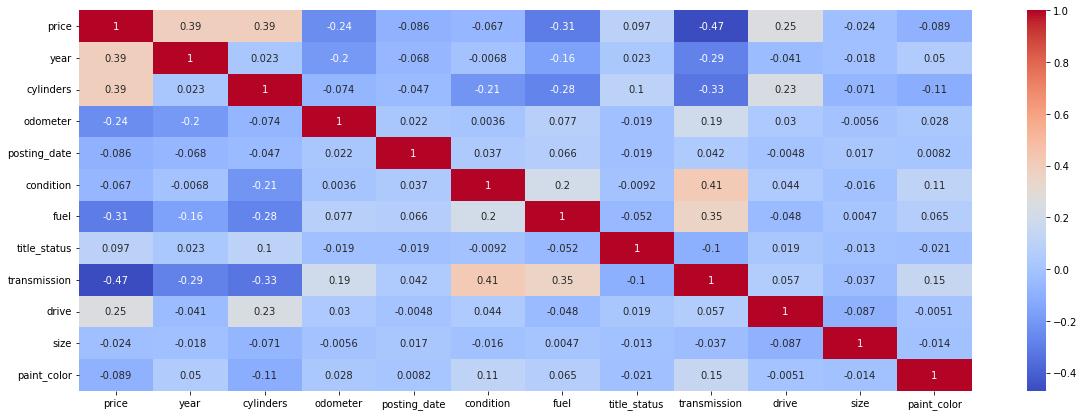

In [63]:
#calculate correlation matris with onehot encoder
corr_matrix_v3 =data_v9.corr()

fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(corr_matrix_v3, cmap='coolwarm', annot=True, annot_kws={'size':10}, )
plt.show()

# Dummy model

Now we finished cleaning, restoring and transforming our dataset, its time to create and train our model!<br>In order to so we define our training and testing dataset by using the train_test_split-split() method.

In [132]:
X = data_v10.drop(columns=['price'])
y = data_v10['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=14564)

In [134]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109831 entries, 203772 to 168172
Columns: 12269 entries, year to type_wagon
dtypes: float64(9), int64(2), uint8(12258)
memory usage: 1.3 GB


Since linear regression is in principle best suited for predicting prices, it is only a logical step that we base our model on it.

In [135]:
dummy_model = LinearRegression()

In [136]:
dummy_model.fit(X_train, y_train)

LinearRegression()

In [137]:
dummy_predict = dummy_model.predict(X_test)

In order to see how well our model performed, we use the r2_score-method.<br>
The score can take different floating point values -∞ to 1. The closer the score is to 1, the more accurately our model performed.

In [138]:
r2_score(dummy_predict,y_test)

0.6320645141169607

For our first attempt the model peformed pretty good.In order to improve our model, see where the errors are, we plot the predicted values ***dummy_predict*** with the true values ***y_test***...

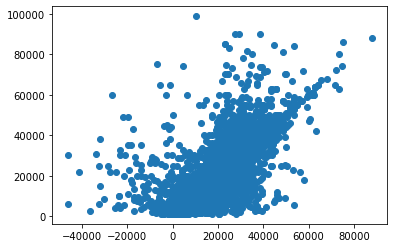

In [139]:
plt.scatter(dummy_predict, y_test)

... and see how the errors are distributed

In [140]:
dummy_errors = y_test - dummy_predict

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 2.000e+00,
        0.000e+00, 3.000e+00, 4.000e+00, 6.000e+00, 6.000e+00, 8.000e+00,
        1.500e+01, 6.000e+00, 2.100e+01, 2.300e+01, 1.900e+01, 4.000e+01,
        4.500e+01, 5.900e+01, 9.200e+01, 1.150e+02, 1.330e+02, 2.160e+02,
        3.180e+02, 5.080e+02, 8.080e+02, 1.260e+03, 1.859e+03, 2.917e+03,
        1.363e+03, 7.250e+02, 4.110e+02, 2.850e+02, 1.430e+02, 1.420e+02,
        8.900e+01, 8.400e+01, 5.700e+01, 5.600e+01, 4.600e+01, 4.400e+01,
        3.800e+01, 2.200e+01, 2.200e+01, 1.300e+01, 1.400e+01, 1.300e+01,
        1.300e+01, 1.500e+01, 4.000e+00, 1.100e+01, 5.000e+00, 8.000e+00,
        7.000e+00, 1.000e+01, 3.000e+00, 5.000e+00, 4.000e+00, 3.000e+00,
        4.000e+00, 3.000e+00, 4.000e+00, 6.000e+00, 2.000e+00, 3.000e+00,
        3.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 3.000e+0

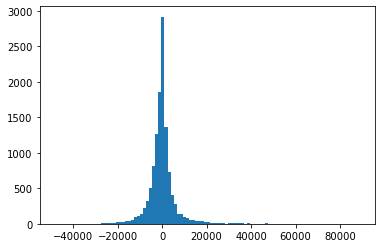

In [141]:
plt.hist(dummy_errors, bins= 100)

Now we see our errors are distributed, we try to improve our model by using the RandomForestRegressor( )...

In [142]:
rnd_model = RandomForestRegressor()

In [143]:
rnd_model.fit(X_train, y_train)

RandomForestRegressor()

In [144]:
rnd_predict = rnd_model.predict(X_test)

... and check the accuracy of this model.

In [145]:
r2_score(rnd_predict,y_test)

0.8960258272381088

As you can see the accuracy of our model improved a lot by changing the ML model.<br> Like in the previous model we want to see where the errors are And plot the predicted values with real values.

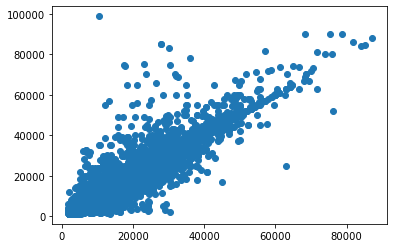

In [146]:
plt.scatter(rnd_predict, y_test)

And see how the deviations are distributed.

In [147]:
errors = y_test - rnd_predict

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 3.000e+00, 4.000e+00, 5.000e+00, 8.000e+00,
        5.000e+00, 1.500e+01, 1.600e+01, 3.500e+01, 4.000e+01, 5.700e+01,
        9.900e+01, 1.350e+02, 2.160e+02, 4.340e+02, 8.790e+02, 2.073e+03,
        5.963e+03, 8.930e+02, 4.680e+02, 2.630e+02, 1.550e+02, 9.700e+01,
        6.000e+01, 5.100e+01, 4.300e+01, 2.800e+01, 3.100e+01, 1.800e+01,
        9.000e+00, 1.400e+01, 1.400e+01, 5.000e+00, 9.000e+00, 6.000e+00,
        1.000e+00, 9.000e+00, 5.000e+00, 0.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

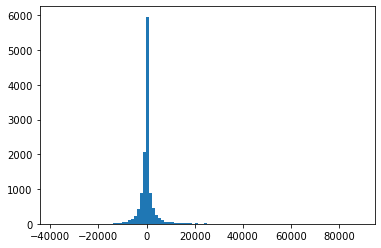

In [148]:
plt.hist(errors, bins= 100)

From the histogram we can see that a very large proportion of the deviations are at 0. <br>From our point of view these deviations are relatively easy to tolerate.

Now we got our model with a great accuracy. Our base goal of our project is done and we can implement it in the Web App. ***Right?***<br> Not quite. As the result from using "get_dummies()"-function to create ***data_v10***, we have 12270 columns. And since we used ***data_v10*** as training data for our model, this means that we would need 12270 instead of the original 13 input variables to use this model.

In [63]:
data_v10.shape

(122035, 12270)

In order to reduce the amount of input varibales we use our last dataset iteration before we used the get_dummies()-function, to train our model. In this case we it would be the ***data_v9*** dataframe. 

In [65]:
data_v9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122035 entries, 1 to 241717
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         122035 non-null  int64  
 1   year          122035 non-null  float64
 2   manufacturer  122035 non-null  object 
 3   model         122035 non-null  object 
 4   cylinders     122035 non-null  int64  
 5   odometer      122035 non-null  float64
 6   type          122035 non-null  object 
 7   posting_date  122035 non-null  int64  
 8   condition     122035 non-null  float64
 9   fuel          122035 non-null  float64
 10  title_status  122035 non-null  float64
 11  transmission  122035 non-null  float64
 12  drive         122035 non-null  float64
 13  size          122035 non-null  float64
 14  paint_color   122035 non-null  float64
dtypes: float64(9), int64(3), object(3)
memory usage: 14.9+ MB


Before we train the model, we define our test and train set for our model.

In [69]:
X = data_v9.drop(columns=['price'])
y = data_v9['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=14564)

After defining that, we specify the columns simply by dividing between numerical and non-numerical columns...

In [70]:
num_cols = X_train.select_dtypes(include=['float']).columns
cat_cols = X_train.select_dtypes(exclude=['float']).columns

... and in order to decode our categorical columns this time we are using the OneHotEncoder instead the get_dummies()-function.

In [71]:
numeric_pipe = make_pipeline(
    SimpleImputer(strategy="mean"))
 
categoric_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    OneHotEncoder(handle_unknown = "ignore")
)

In [96]:
#creating a linear regressop
#dummy_model = LinearRegression()

In [105]:
#dummy_model.fit(X_train, y_train)

After that we integrate our encoders and imputers into our pipeline... 

In [72]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, num_cols),
        ("cat_pipe", categoric_pipe, cat_cols)])

full_pipeline = make_pipeline(preprocessor, 
                              RandomForestRegressor())

... , train it with the data from ***data_v9***...

In [66]:
full_pipeline.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['year', 'odometer', 'condition', 'fuel', 'title_status', 'transmission',
       'drive', 'size', 'paint_color'],
      dtype='object')),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='N_A',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignor

...,testing it...

In [80]:
x_pred=full_pipeline.predict(X_test)

and measuring its accuracy by using r2_score( ) 

In [ ]:
r2_score(x_pred,y_test)

And as you can see the accuracy of this model is still the same. Using the OneHotEncoder is a more simple and especially a more efficient way (99% of the PC would probably crash trying to train the first model) to encode the categorical columns.  

In [75]:
pickle.dump(full_pipeline, 
            open(file='/Users/huyduc/Documents/Notebooks/Final Project/Models/rf_pipe.sav', 
                 mode='wb'))                                      

In our next step we implemented the GridSearchCV and the MinMaxScaler( )into our model and trained and tested the model again.

In [84]:
#best cv value: 4
numeric_pipe = make_pipeline(
    SimpleImputer(strategy="mean"), MinMaxScaler())
 
categoric_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    OneHotEncoder(handle_unknown = "ignore")
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, num_cols),
        ("cat_pipe", categoric_pipe, cat_cols)])

full_pipeline = make_pipeline(preprocessor, 
                              RandomForestRegressor())
param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median"],
    "columntransformer__cat_pipe__simpleimputer__strategy":["most_frequent","constant"]
}
gridsearch_it01 = GridSearchCV(full_pipeline,param_grid,cv=4,verbose=1)
gridsearch_it01.fit(X_train,y_train)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         Index(['year', 'odometer', 'condition', 'fuel', 'title_status', 'transmission',
       'drive', 'size', 'paint_color'],
      dtype='object')),
                                                                        ('cat_pipe',
                                                                         Pipeline(steps=[('simple...
  

In [86]:
X_pred=gridsearch_it01.predict(X_test)

In [87]:
r2_score(X_pred,y_test)

0.894146990019239

As you can compare the r2_score from our new model and our previous model, the accurracy barely(<1%) improved. Given that it took more than 6 hours to train the model with the implemented GridSearchCV, in our case it was not worth the wait, compared to the 1 hour of our previous model.

But a small improvement is still an improvement after all, and thats why we are saving this model and using it for our WebApp. 

In [118]:
pickle.dump(gridsearch_it01, 
            open(file='./Models/rf_gscv.sav', 
                 mode='wb'))

## Other (and maybe better?) methods to create a model for the price prediction of used cars

### CatBoost Improvement Iteration 01

Given that this process of creating and training our previous models,took a lot of time for our computers to process, we asked ourselves: <br>"Are there more efficient or better ways to do it?" According to Google.com the Answer to our question was ***CatBoost***. So what is ***CatBoost***? According to their [website](https://catboost.ai/en/docs/), it is a machine learning algorithm that uses gradient boosting on decision trees. 

But before we do that we create create function, that shows the difference between training score and validation in order to see to what degree overfitting takes place and...


In [64]:
def print_scores(y_train, y_valid, y_pred_train, y_pred_valid):
    train_score = r2_score(y_train, y_pred_train)
    print('------ Train Scores ------')
    print('R2 Score:', train_score)

    print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred_train))
    print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred_train))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

    valid_score = r2_score(y_valid, y_pred_valid)
    print('------ Validation Scores ------')
    print('R2 Score:', valid_score)

    print('Mean Absolute Error:', metrics.mean_absolute_error(y_valid, y_pred_valid))
    print('Mean Squared Error:', metrics.mean_squared_error(y_valid, y_pred_valid))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, y_pred_valid)))

In [65]:
# Seed is used for randomization of processes. With the same seed, we can always reproduce the results.
SEED = 256

... again define our train-and-test dataset.

In [66]:
data_v9.describe()

,price,year,cylinders,odometer,posting_date,condition,fuel,title_status,transmission,drive,size,paint_color
count,122035.000000,122035.000000,122035.000000,1.220350e+05,1.220350e+05,122035.000000,122035.000000,122035.000000,122035.000000,122035.000000,122035.000000,122035.000000
mean,17960.317335,2010.986709,6.420322,9.447312e+04,2.021044e+07,2.517663,1.803696,4.880559,1.429090,0.989978,0.992904,2.969214
std,12936.055171,9.212154,1.657810,1.735817e+05,3.785228e+01,0.701707,0.621409,0.629751,0.867508,0.799913,0.632535,1.252349
min,1057.000000,1900.000000,0.000000,0.000000e+00,2.021040e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,7194.000000,2008.000000,6.000000,3.442500e+04,2.021042e+07,2.000000,2.000000,5.000000,0.000000,0.000000,1.000000,2.000000
50%,14990.000000,2013.000000,6.000000,8.316000e+04,2.021043e+07,2.000000,2.000000,5.000000,2.000000,1.000000,1.000000,3.000000
75%,26990.000000,2017.000000,8.000000,1.340600e+05,2.021050e+07,3.000000,2.000000,5.000000,2.000000,2.000000,1.000000,4.000000
max,99999.000000,2022.000000,12.000000,1.000000e+07,2.021050e+07,5.000000,4.000000,5.000000,2.000000,2.000000,3.000000,5.000000


In [67]:
data_v9_2 = data_v9.reset_index(drop= True)
data_v9_2

,price,year,manufacturer,model,cylinders,odometer,type,posting_date,condition,fuel,title_status,transmission,drive,size,paint_color
0,22590,2010.0,chevrolet,silverado 1500,8,71229.0,pickup,20210504,2.0,2.0,5.0,0.0,1.0,1.0,1.0
1,39590,2020.0,chevrolet,silverado 1500 crew,8,19160.0,pickup,20210504,2.0,2.0,5.0,0.0,1.0,1.0,2.0
2,30990,2017.0,toyota,tundra double cab sr,8,41124.0,pickup,20210504,2.0,2.0,5.0,0.0,1.0,1.0,2.0
3,15000,2013.0,ford,f-150 xlt,6,128000.0,truck,20210503,3.0,2.0,5.0,2.0,1.0,1.0,3.0
4,27990,2012.0,gmc,sierra 2500 hd extended cab,8,68696.0,pickup,20210503,2.0,2.0,5.0,0.0,2.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122030,34590,2020.0,alfa-romeo,romeo giulia sedan 4d,8,2498.0,sedan,20210405,2.0,0.0,5.0,0.0,1.0,1.0,3.0
122031,32990,2016.0,infiniti,qx80 sport utility 4d,8,55612.0,other,20210405,2.0,2.0,5.0,2.0,1.0,1.0,3.0
122032,22990,2020.0,hyundai,sonata se sedan 4d,8,3066.0,sedan,20210404,2.0,2.0,5.0,0.0,0.0,1.0,1.0
122033,30590,2020.0,volvo,s60 t5 momentum sedan 4d,8,12029.0,sedan,20210404,2.0,2.0,5.0,0.0,0.0,1.0,2.0


In [68]:
X_train, X_valid, y_train, y_valid = train_test_split(data_v9_2.drop('price', axis=1), data_v9_2['price'], test_size=0.2, random_state=SEED)

Catboost requires to know which features are categorical. For this, we need to provide the indices of categorical features.

In [69]:
cat_features = [1, 2, 5]
cat_features

[1, 2, 5]

Pool is a datatype from Catboost to efficiently handle datasets, so we use that instead of X_train, and X_test for the model training and testing later.

In [74]:
train_data = Pool(data=X_train, label=y_train, cat_features=cat_features)
valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_features)

Now we create our first simple model based on CatBoost, ...

In [77]:
%%time

cbr_def = CatBoostRegressor(#task_type='GPU', 
                            verbose=200, random_seed=SEED)
# task_type --> we can specify to use GPU
# verbose --> select after how many iterations we want to see scores
# Rest parameters are set to default

CPU times: user 157 µs, sys: 395 µs, total: 552 µs
Wall time: 1.55 ms


... training it...

In [78]:
cbr_def.fit(train_data,
          eval_set=valid_data,
          use_best_model=True,
          plot=True)
# eval_set --> specify validation set which is used for overfit detection
# use_best_model --> this is available only when eval_set is specified. Use the best model after overfit detection
# plot --> True for visualizing plots

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.104534
0:	learn: 12074.6409512	test: 12043.7615891	best: 12043.7615891 (0)	total: 97.8ms	remaining: 1m 37s
200:	learn: 4934.0078744	test: 5069.7765111	best: 5069.7765111 (200)	total: 4.24s	remaining: 16.9s
400:	learn: 4542.2297529	test: 4752.4150329	best: 4752.4150329 (400)	total: 7.84s	remaining: 11.7s
600:	learn: 4307.7372074	test: 4587.7782547	best: 4587.7323315 (599)	total: 11.2s	remaining: 7.41s
800:	learn: 4156.2406023	test: 4491.2370555	best: 4490.8111876 (799)	total: 14.7s	remaining: 3.64s
999:	learn: 4033.7822149	test: 4413.6928210	best: 4413.6928210 (999)	total: 18s	remaining: 0us

bestTest = 4413.692821
bestIteration = 999



... and measuring its overall accuracy.

In [81]:
y_pred_train_cbr_def = cbr_def.predict(train_data)
y_pred_valid_cbr_def = cbr_def.predict(valid_data)

print_scores(y_train, y_valid, y_pred_train_cbr_def, y_pred_valid_cbr_def)

------ Train Scores ------
R2 Score: 0.9084290168354034
Mean Absolute Error: 2382.60885429657
Mean Squared Error: 15339692.926090874
Root Mean Squared Error: 3916.5920040375504
------ Validation Scores ------
R2 Score: 0.8830915393938186
Mean Absolute Error: 2556.709867182838
Mean Squared Error: 19480684.317947805
Root Mean Squared Error: 4413.692820977441


As you can see the overall accuracy isn't as good as our previous models, but given the fact, that this model is basically a dummy model, the results were pretty good.

### CatBoost Improvement Iteration 02

Now lets try to improve the results of this by using hyper-parameter tuning. For large datasets, it is convenient to use RandomizedSearch instead of GridSearch. The results depend on parameters chosen randomly, but it is efficient time-wise for large datasets.<br> To get better results GridSearch is still the way to go, but for time we trying to improve the model on other layers, we use RandomizedSearch.

In [82]:
param_grid = {'learning_rate':[0.01, 0.03, 0.05, 0.1],
        'depth':[2, 4, 6, 8, 10],
        'l2_leaf_reg':[1, 3, 5, 7, 9, 11],
        'iterations':[150, 250, 500, 750]}

cbr_rgs = CatBoostRegressor(#task_type='GPU', 
                            verbose=200, random_seed=SEED)

random_grid_search_result = cbr_rgs.randomized_search(param_grid,
                                        X=train_data,
                                        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 21617.7111626	test: 21530.5205269	best: 21530.5205269 (0)	total: 15.5ms	remaining: 3.85s
200:	learn: 6688.2584500	test: 6572.2439051	best: 6572.2439051 (200)	total: 2.17s	remaining: 528ms
249:	learn: 6572.2605259	test: 6459.3944376	best: 6459.3944376 (249)	total: 2.65s	remaining: 0us

bestTest = 6459.394438
bestIteration = 249

0:	loss: 6459.3944376	best: 6459.3944376 (0)	total: 2.71s	remaining: 24.3s
0:	learn: 20362.3602595	test: 20274.8039060	best: 20274.8039060 (0)	total: 13.1ms	remaining: 9.82s
200:	learn: 6157.0891684	test: 6051.3190416	best: 6051.3190416 (200)	total: 2.22s	remaining: 6.06s
400:	learn: 5892.4447651	test: 5782.8327203	best: 5782.8327203 (400)	total: 4.08s	remaining: 3.55s
600:	learn: 5720.1086602	test: 5621.3307158	best: 5621.3015802 (599)	total: 6.3s	remaining: 1.56s
749:	learn: 5634.2712735	test: 5536.7512425	best: 5536.7512425 (749)	total: 7.95s	remaining: 0us

bestTest = 5536.751242
bestIteration = 749

1:	loss: 5536.7512425	best: 5536.7512425 (1)	tot

In [83]:
y_pred_train_cbr_rgs = cbr_rgs.predict(train_data)
y_pred_valid_cbr_rgs = cbr_rgs.predict(valid_data)

print_scores(y_train, y_valid, y_pred_train_cbr_rgs, y_pred_valid_cbr_rgs)

------ Train Scores ------
R2 Score: 0.9267143089248607
Mean Absolute Error: 2089.80989838799
Mean Squared Error: 12276596.342187453
Root Mean Squared Error: 3503.7974174012193
------ Validation Scores ------
R2 Score: 0.8938189953283809
Mean Absolute Error: 2344.814336911826
Mean Squared Error: 17693147.457806684
Root Mean Squared Error: 4206.322319771356


 to find out, how the features impacts the price according to Catboost.

Text(0.5, 1.0, 'CatBoost Feature Importance')

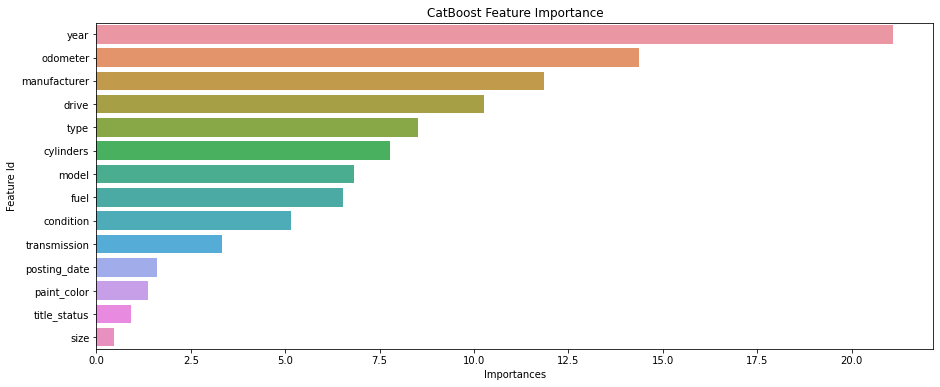

In [85]:
importances = pd.DataFrame(cbr_rgs.get_feature_importance(prettified=True))
plt.figure(figsize=(15, 6))
sns.barplot(data=importances.sort_values('Importances', ascending=False), x='Importances', y='Feature Id')
plt.title('CatBoost Feature Importance')

Now back to our model we are trying to improve. we assign the value 15 to the paratermeter ***n_iter***, which is the number of parameter settings that are sampled.

In [86]:
%%time

grid = {'learning_rate':[0.01, 0.03, 0.05, 0.1, 0.15],
        'depth':[2, 4, 6, 8, 10],
        'l2_leaf_reg':[1, 3, 5, 7, 9, 11],
        'iterations':[150, 250, 500, 750]}

cbr_rgs_2 = CatBoostRegressor(#task_type='GPU', 
                              verbose=200, random_seed=SEED)

grid_search_result_2 = cbr_rgs_2.randomized_search(grid,
                                        X=train_data,
                                        n_iter=15,
                                        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 21257.2724468	test: 21169.9770366	best: 21169.9770366 (0)	total: 9.3ms	remaining: 4.64s
200:	learn: 6427.4249636	test: 6323.4383234	best: 6323.4383234 (200)	total: 1.69s	remaining: 2.51s
400:	learn: 6163.0055447	test: 6061.3017657	best: 6061.3017657 (400)	total: 3.35s	remaining: 827ms
499:	learn: 6081.9335388	test: 5978.9208851	best: 5978.9208851 (499)	total: 4.08s	remaining: 0us

bestTest = 5978.920885
bestIteration = 499

0:	loss: 5978.9208851	best: 5978.9208851 (0)	total: 4.13s	remaining: 57.9s
0:	learn: 20363.1579998	test: 20275.5982736	best: 20275.5982736 (0)	total: 12.7ms	remaining: 6.33s
200:	learn: 6162.9747826	test: 6063.4051241	best: 6063.4051241 (200)	total: 2.15s	remaining: 3.2s
400:	learn: 5907.9473762	test: 5803.8008148	best: 5803.8008148 (400)	total: 3.69s	remaining: 910ms
499:	learn: 5828.6191580	test: 5724.6766761	best: 5724.6766761 (499)	total: 4.52s	remaining: 0us

bestTest = 5724.676676
bestIteration = 499

1:	loss: 5724.6766761	best: 5724.6766761 (1)	tota

600:	learn: 3669.8404557	test: 4324.5619862	best: 4324.5619862 (600)	total: 14.6s	remaining: 3.62s
749:	learn: 3516.8005289	test: 4278.7072003	best: 4278.7072003 (749)	total: 18.3s	remaining: 0us

bestTest = 4278.7072
bestIteration = 749

Training on fold [2/3]
0:	learn: 19318.2510585	test: 19250.2319451	best: 19250.2319451 (0)	total: 31.7ms	remaining: 23.7s
200:	learn: 4412.7746900	test: 4689.5808246	best: 4689.5808246 (200)	total: 5.07s	remaining: 13.9s
400:	learn: 3945.9863724	test: 4422.8604251	best: 4422.7875634 (399)	total: 10.1s	remaining: 8.75s
600:	learn: 3657.9284767	test: 4298.0978359	best: 4298.0978359 (600)	total: 15s	remaining: 3.72s
749:	learn: 3509.3497727	test: 4243.1143161	best: 4243.1143161 (749)	total: 18.5s	remaining: 0us

bestTest = 4243.114316
bestIteration = 749

CPU times: user 15min 56s, sys: 2min 10s, total: 18min 6s
Wall time: 3min 22s


In [87]:
y_pred_train_cbr_rgs_2 = cbr_rgs_2.predict(train_data)
y_pred_valid_cbr_rgs_2 = cbr_rgs_2.predict(valid_data)

print_scores(y_train, y_valid, y_pred_train_cbr_rgs_2, y_pred_valid_cbr_rgs_2)

------ Train Scores ------
R2 Score: 0.925698534494352
Mean Absolute Error: 2122.4948439446907
Mean Squared Error: 12446755.789074374
Root Mean Squared Error: 3527.9960018506786
------ Validation Scores ------
R2 Score: 0.8943952203950247
Mean Absolute Error: 2372.2297558561777
Mean Squared Error: 17597129.953503136
Root Mean Squared Error: 4194.893318488938


As you can the see the model improved its accuracy, while the training score has outperformed the r2_score of our old model, the test score is still behind that of the old model.

### CatBoost Improvement Iteration 03

Now in our third iteration we try to improve the model by chaning the ***n_iter*** from 15 to 25.

In [91]:
%%time

grid = {'learning_rate':[0.01, 0.03, 0.05, 0.1, 0.15],
        'depth':[2, 4, 6, 8, 10],
        'l2_leaf_reg':[1, 3, 5, 7, 9, 11],
        'iterations':[150, 250, 500, 750]}

cbr_rgs_3 = CatBoostRegressor(#task_type='GPU', 
                              verbose=200)
    #, random_seed=SEED)

grid_search_result_3 = cbr_rgs_3.randomized_search(grid,
                                        X=train_data,
                                        n_iter=25,
                                        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 21258.4617801	test: 21173.2883922	best: 21173.2883922 (0)	total: 15.6ms	remaining: 3.89s
200:	learn: 6438.6265439	test: 6324.5271188	best: 6324.5271188 (200)	total: 1.95s	remaining: 475ms
249:	learn: 6346.4950546	test: 6234.3996557	best: 6234.3996557 (249)	total: 2.46s	remaining: 0us

bestTest = 6234.399656
bestIteration = 249

0:	loss: 6234.3996557	best: 6234.3996557 (0)	total: 2.51s	remaining: 1m
0:	learn: 21258.7492597	test: 21173.5808338	best: 21173.5808338 (0)	total: 11.6ms	remaining: 5.77s
200:	learn: 6440.5181899	test: 6328.4711918	best: 6328.4711918 (200)	total: 2.03s	remaining: 3.02s
400:	learn: 6175.2166213	test: 6058.5039455	best: 6058.5039455 (400)	total: 3.75s	remaining: 926ms
499:	learn: 6087.5365644	test: 5973.0676878	best: 5973.0676878 (499)	total: 4.61s	remaining: 0us

bestTest = 5973.067688
bestIteration = 499

1:	loss: 5973.0676878	best: 5973.0676878 (1)	total: 7.14s	remaining: 1m 22s
0:	learn: 20366.2189164	test: 20282.9656252	best: 20282.9656252 (0)	total

200:	learn: 4400.5987815	test: 4553.1673614	best: 4552.9709366 (199)	total: 5.17s	remaining: 14.1s
400:	learn: 3948.8616469	test: 4300.3289433	best: 4300.3289433 (400)	total: 10.3s	remaining: 8.97s
600:	learn: 3694.9049597	test: 4193.2410703	best: 4193.2142490 (599)	total: 15.3s	remaining: 3.8s
749:	learn: 3540.5619060	test: 4128.2096675	best: 4128.2096675 (749)	total: 19s	remaining: 0us

bestTest = 4128.209668
bestIteration = 749

18:	loss: 4128.2096675	best: 4128.2096675 (18)	total: 2m 27s	remaining: 46.4s
0:	learn: 21578.4926302	test: 21492.4034398	best: 21492.4034398 (0)	total: 18.9ms	remaining: 2.81s
149:	learn: 5250.7294526	test: 5315.0900331	best: 5315.0900331 (149)	total: 2.44s	remaining: 0us

bestTest = 5315.090033
bestIteration = 149

19:	loss: 5315.0900331	best: 4128.2096675 (18)	total: 2m 29s	remaining: 37.4s
0:	learn: 21587.0879614	test: 21501.4714344	best: 21501.4714344 (0)	total: 16.9ms	remaining: 2.52s
149:	learn: 5345.5492310	test: 5372.1077060	best: 5372.1077060 (149)

In [92]:
y_pred_train_cbr_rgs_3 = cbr_rgs_3.predict(train_data)
y_pred_valid_cbr_rgs_3 = cbr_rgs_3.predict(valid_data)

print_scores(y_train, y_valid, y_pred_train_cbr_rgs_3, y_pred_valid_cbr_rgs_3)

------ Train Scores ------
R2 Score: 0.9334003730013732
Mean Absolute Error: 1977.7317363916645
Mean Squared Error: 11156567.198965129
Root Mean Squared Error: 3340.1447871260207
------ Validation Scores ------
R2 Score: 0.8984340103511396
Mean Absolute Error: 2256.9191770333914
Mean Squared Error: 16924138.522826377
Root Mean Squared Error: 4113.895784147476


In our third iteration, we were now able to beat our previous model at the test score and validation score.

After seeing the results of using CatBoost with RandomizedSearch. It is time to "combine" GridSearch CV and Catboost.

In [93]:
#Defining a new CatBoostRegressor Instance
cbr_rgs_4 = CatBoostRegressor(#task_type='GPU','
                              verbose=200)

In [95]:
#Implementing gridsearch into our new CatBoostRegressor Instance and model training
grid_search_result_4=cbr_rgs_4.grid_search(grid,X=train_data,cv=4,plot=True)
y_pred_train_cbr_rgs_4 = cbr_rgs_4.predict(train_data)
y_pred_valid_cbr_rgs_4 = cbr_rgs_4.predict(valid_data)
print_scores(y_train, y_valid, y_pred_train_cbr_rgs_4, y_pred_valid_cbr_rgs_4)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 21979.7944705	test: 21893.1288738	best: 21893.1288738 (0)	total: 10.8ms	remaining: 1.61s
149:	learn: 9346.1663545	test: 9287.4044168	best: 9287.4044168 (149)	total: 895ms	remaining: 0us

bestTest = 9287.404417
bestIteration = 149

0:	loss: 9287.4044168	best: 9287.4044168 (0)	total: 939ms	remaining: 9m 22s
0:	learn: 21618.4185771	test: 21532.4959464	best: 21532.4959464 (0)	total: 11.3ms	remaining: 1.68s
149:	learn: 6915.2873561	test: 6794.3586592	best: 6794.3586592 (149)	total: 1.15s	remaining: 0us

bestTest = 6794.358659
bestIteration = 149

1:	loss: 6794.3586592	best: 6794.3586592 (1)	total: 2.1s	remaining: 10m 29s
0:	learn: 21258.4617801	test: 21173.2883922	best: 21173.2883922 (0)	total: 8.3ms	remaining: 1.24s
149:	learn: 6591.3926812	test: 6480.3770731	best: 6480.3770731 (149)	total: 1000ms	remaining: 0us

bestTest = 6480.377073
bestIteration = 149

2:	loss: 6480.3770731	best: 6480.3770731 (2)	total: 3.12s	remaining: 10m 19s
0:	learn: 20365.2716320	test: 20282.0019859	best

149:	learn: 6905.4426227	test: 6788.2669134	best: 6788.2669134 (149)	total: 1.27s	remaining: 0us

bestTest = 6788.266913
bestIteration = 149

26:	loss: 6788.2669134	best: 6054.0616820 (9)	total: 29.9s	remaining: 10m 35s
0:	learn: 21258.9407181	test: 21173.7755895	best: 21173.7755895 (0)	total: 8.34ms	remaining: 1.24s
149:	learn: 6592.5483126	test: 6481.0027527	best: 6481.0027527 (149)	total: 1.08s	remaining: 0us

bestTest = 6481.002753
bestIteration = 149

27:	loss: 6481.0027527	best: 6054.0616820 (9)	total: 31s	remaining: 10m 33s
0:	learn: 20366.2189164	test: 20282.9656252	best: 20282.9656252 (0)	total: 7.41ms	remaining: 1.1s
149:	learn: 6321.2608405	test: 6211.6444737	best: 6211.6444737 (149)	total: 1.1s	remaining: 0us

bestTest = 6211.644474
bestIteration = 149

28:	loss: 6211.6444737	best: 6054.0616820 (9)	total: 32.1s	remaining: 10m 32s
0:	learn: 19484.1099754	test: 19402.8190400	best: 19402.8190400 (0)	total: 10.6ms	remaining: 1.58s
149:	learn: 6171.3696225	test: 6066.3732022	bes

200:	learn: 6440.5181899	test: 6328.4711918	best: 6328.4711918 (200)	total: 1.46s	remaining: 357ms
249:	learn: 6351.0895412	test: 6239.1898960	best: 6239.1898960 (249)	total: 1.81s	remaining: 0us

bestTest = 6239.189896
bestIteration = 249

47:	loss: 6239.1898960	best: 5802.5268219 (39)	total: 1m 17s	remaining: 14m 50s
0:	learn: 20365.8402294	test: 20282.5804089	best: 20282.5804089 (0)	total: 9.14ms	remaining: 2.28s
200:	learn: 6177.5439504	test: 6058.9743858	best: 6058.9743858 (200)	total: 1.41s	remaining: 343ms
249:	learn: 6091.5457826	test: 5974.6918974	best: 5974.6918974 (249)	total: 1.76s	remaining: 0us

bestTest = 5974.691897
bestIteration = 249

48:	loss: 5974.6918974	best: 5802.5268219 (39)	total: 1m 19s	remaining: 14m 50s
0:	learn: 19483.5491775	test: 19402.2485639	best: 19402.2485639 (0)	total: 8.16ms	remaining: 2.03s
200:	learn: 6030.0895339	test: 5910.7547034	best: 5910.7547034 (200)	total: 1.4s	remaining: 340ms
249:	learn: 5942.5391762	test: 5824.9614798	best: 5824.9614798

499:	learn: 6812.3688269	test: 6687.2387901	best: 6687.2387901 (499)	total: 3.7s	remaining: 0us

bestTest = 6687.23879
bestIteration = 499

65:	loss: 6687.2387901	best: 5538.1794182 (64)	total: 2m 4s	remaining: 16m 47s
0:	learn: 21618.4763292	test: 21532.5546958	best: 21532.5546958 (0)	total: 7.48ms	remaining: 3.73s
200:	learn: 6691.3246054	test: 6567.9019421	best: 6567.9019421 (200)	total: 1.26s	remaining: 1.88s
400:	learn: 6370.0122403	test: 6255.8287183	best: 6255.8287183 (400)	total: 2.55s	remaining: 630ms
499:	learn: 6284.6487145	test: 6166.9020201	best: 6166.9020201 (499)	total: 3.18s	remaining: 0us

bestTest = 6166.90202
bestIteration = 499

66:	loss: 6166.9020201	best: 5538.1794182 (64)	total: 2m 7s	remaining: 16m 55s
0:	learn: 21258.5576456	test: 21173.3859139	best: 21173.3859139 (0)	total: 6.63ms	remaining: 3.31s
200:	learn: 6436.8667898	test: 6329.4221188	best: 6329.4221188 (200)	total: 1.33s	remaining: 1.97s
400:	learn: 6171.6967702	test: 6058.1251744	best: 6058.1251744 (40

499:	learn: 6277.2211141	test: 6165.7617460	best: 6165.7617460 (499)	total: 3.17s	remaining: 0us

bestTest = 6165.761746
bestIteration = 499

81:	loss: 6165.7617460	best: 5529.4801279 (79)	total: 2m 56s	remaining: 18m 35s
0:	learn: 21258.8450083	test: 21173.6782321	best: 21173.6782321 (0)	total: 7.23ms	remaining: 3.61s
200:	learn: 6449.4318744	test: 6338.1974369	best: 6338.1974369 (200)	total: 1.31s	remaining: 1.95s
400:	learn: 6174.5743487	test: 6057.8622189	best: 6057.8622189 (400)	total: 2.64s	remaining: 652ms
499:	learn: 6088.9542756	test: 5973.4308147	best: 5973.4308147 (499)	total: 3.31s	remaining: 0us

bestTest = 5973.430815
bestIteration = 499

82:	loss: 5973.4308147	best: 5529.4801279 (79)	total: 2m 59s	remaining: 18m 40s
0:	learn: 20366.0296107	test: 20282.7730569	best: 20282.7730569 (0)	total: 8.38ms	remaining: 4.18s
200:	learn: 6181.6494867	test: 6067.4737399	best: 6067.4737399 (200)	total: 1.34s	remaining: 2s
400:	learn: 5910.0911875	test: 5793.4761119	best: 5793.4761119 (

400:	learn: 6370.0122403	test: 6255.8287183	best: 6255.8287183 (400)	total: 2.56s	remaining: 2.23s
600:	learn: 6215.2873832	test: 6094.4874097	best: 6094.4874097 (600)	total: 3.93s	remaining: 974ms
749:	learn: 6133.4195273	test: 6011.6392134	best: 6011.6392134 (749)	total: 4.87s	remaining: 0us

bestTest = 6011.639213
bestIteration = 749

96:	loss: 6011.6392134	best: 5394.3084219 (94)	total: 3m 56s	remaining: 20m 28s
0:	learn: 21258.5576456	test: 21173.3859139	best: 21173.3859139 (0)	total: 8.61ms	remaining: 6.45s
200:	learn: 6436.8667898	test: 6329.4221188	best: 6329.4221188 (200)	total: 1.34s	remaining: 3.67s
400:	learn: 6171.6967702	test: 6058.1251744	best: 6058.1251744 (400)	total: 2.61s	remaining: 2.27s
600:	learn: 6016.3163746	test: 5901.6742749	best: 5901.6742749 (600)	total: 3.87s	remaining: 960ms
749:	learn: 5931.3426829	test: 5820.0609969	best: 5820.0609969 (749)	total: 4.78s	remaining: 0us

bestTest = 5820.060997
bestIteration = 749

97:	loss: 5820.0609969	best: 5394.3084219 

749:	learn: 5517.5417336	test: 5410.9433397	best: 5410.9433397 (749)	total: 5.65s	remaining: 0us

bestTest = 5410.94334
bestIteration = 749

109:	loss: 5410.9433397	best: 5394.3084219 (94)	total: 5m	remaining: 22m 19s
0:	learn: 21979.8717210	test: 21893.2074555	best: 21893.2074555 (0)	total: 7.6ms	remaining: 5.69s
200:	learn: 8300.7957353	test: 8245.5124569	best: 8245.5124569 (200)	total: 1.4s	remaining: 3.82s
400:	learn: 6997.5071531	test: 6875.0714427	best: 6875.0714427 (400)	total: 2.67s	remaining: 2.32s
600:	learn: 6690.6822314	test: 6566.8227265	best: 6566.8227265 (600)	total: 3.99s	remaining: 989ms
749:	learn: 6570.3387300	test: 6453.5562887	best: 6453.5562887 (749)	total: 4.95s	remaining: 0us

bestTest = 6453.556289
bestIteration = 749

110:	loss: 6453.5562887	best: 5394.3084219 (94)	total: 5m 5s	remaining: 22m 26s
0:	learn: 21618.6494439	test: 21532.7307942	best: 21532.7307942 (0)	total: 9.34ms	remaining: 6.99s
200:	learn: 6682.7752197	test: 6564.6562438	best: 6564.6562438 (200

149:	learn: 6310.2131867	test: 6230.0020518	best: 6230.0020518 (149)	total: 1.14s	remaining: 0us

bestTest = 6230.002052
bestIteration = 149

126:	loss: 6230.0020518	best: 5379.8580659 (124)	total: 5m 57s	remaining: 22m 12s
0:	learn: 21225.9152174	test: 21139.1002728	best: 21139.1002728 (0)	total: 9.23ms	remaining: 1.38s
149:	learn: 6006.6731815	test: 5907.3183129	best: 5907.3183129 (149)	total: 1.21s	remaining: 0us

bestTest = 5907.318313
bestIteration = 149

127:	loss: 5907.3183129	best: 5379.8580659 (124)	total: 5m 58s	remaining: 22m 3s
0:	learn: 20298.9728734	test: 20212.3415525	best: 20212.3415525 (0)	total: 8.86ms	remaining: 1.32s
149:	learn: 5652.5869199	test: 5559.2425050	best: 5559.2425050 (149)	total: 1.18s	remaining: 0us

bestTest = 5559.242505
bestIteration = 149

128:	loss: 5559.2425050	best: 5379.8580659 (124)	total: 6m	remaining: 21m 54s
0:	learn: 19381.3330982	test: 19294.8488762	best: 19294.8488762 (0)	total: 9.36ms	remaining: 1.39s
149:	learn: 5481.9606986	test: 5415.

249:	learn: 5986.2440548	test: 5888.0898313	best: 5888.0898313 (249)	total: 2.99s	remaining: 0us

bestTest = 5888.089831
bestIteration = 249

151:	loss: 5888.0898313	best: 5379.8580659 (124)	total: 6m 30s	remaining: 19m 12s
0:	learn: 21207.8300877	test: 21122.9424356	best: 21122.9424356 (0)	total: 14.1ms	remaining: 3.52s
200:	learn: 5820.7793943	test: 5725.4366979	best: 5725.4366979 (200)	total: 2.42s	remaining: 590ms
249:	learn: 5704.3632214	test: 5611.9235934	best: 5611.9235934 (249)	total: 2.98s	remaining: 0us

bestTest = 5611.923593
bestIteration = 249

152:	loss: 5611.9235934	best: 5379.8580659 (124)	total: 6m 33s	remaining: 19m 10s
0:	learn: 20262.1295971	test: 20179.3075923	best: 20179.3075923 (0)	total: 16.6ms	remaining: 4.14s
200:	learn: 5457.7644583	test: 5362.4248759	best: 5362.4248759 (200)	total: 2.53s	remaining: 616ms
249:	learn: 5334.5276137	test: 5245.8133463	best: 5245.8133463 (249)	total: 3.12s	remaining: 0us

bestTest = 5245.813346
bestIteration = 249

153:	loss: 524

200:	learn: 6106.4222814	test: 6007.9836616	best: 6007.9836616 (200)	total: 2.51s	remaining: 613ms
249:	learn: 5996.9533021	test: 5892.3645930	best: 5892.3645930 (249)	total: 3.25s	remaining: 0us

bestTest = 5892.364593
bestIteration = 249

171:	loss: 5892.3645930	best: 5074.9599112 (154)	total: 11m 13s	remaining: 27m 55s
0:	learn: 21209.4764059	test: 21124.6082573	best: 21124.6082573 (0)	total: 15.2ms	remaining: 3.77s
200:	learn: 5859.5855131	test: 5753.8044659	best: 5753.8044659 (200)	total: 2.65s	remaining: 647ms
249:	learn: 5741.2481738	test: 5637.6295274	best: 5637.6295274 (249)	total: 3.33s	remaining: 0us

bestTest = 5637.629527
bestIteration = 249

172:	loss: 5637.6295274	best: 5074.9599112 (154)	total: 11m 16s	remaining: 27m 50s
0:	learn: 20265.3965974	test: 20182.6115681	best: 20182.6115681 (0)	total: 18ms	remaining: 4.48s
200:	learn: 5499.2909902	test: 5414.8621575	best: 5414.8621575 (200)	total: 3.03s	remaining: 739ms
249:	learn: 5376.7557059	test: 5294.0675814	best: 5294.06

200:	learn: 5260.9473240	test: 5185.8548908	best: 5185.8548908 (200)	total: 2.42s	remaining: 3.6s
400:	learn: 4923.2489322	test: 4902.5921453	best: 4902.5921453 (400)	total: 4.86s	remaining: 1.2s
499:	learn: 4820.3071303	test: 4822.5717063	best: 4822.5717063 (499)	total: 6.24s	remaining: 0us

bestTest = 4822.571706
bestIteration = 499

189:	loss: 4822.5717063	best: 4808.2682078 (184)	total: 12m 44s	remaining: 27m 28s
0:	learn: 21969.9771683	test: 21883.3787898	best: 21883.3787898 (0)	total: 14.9ms	remaining: 7.46s
200:	learn: 7638.2211910	test: 7587.2525257	best: 7587.2525257 (200)	total: 2.54s	remaining: 3.77s
400:	learn: 6372.0598714	test: 6281.7330581	best: 6281.7330581 (400)	total: 4.72s	remaining: 1.17s
499:	learn: 6214.3745495	test: 6117.6739374	best: 6117.6739374 (499)	total: 5.86s	remaining: 0us

bestTest = 6117.673937
bestIteration = 499

190:	loss: 6117.6739374	best: 4808.2682078 (184)	total: 12m 49s	remaining: 27m 28s
0:	learn: 21588.7554806	test: 21503.0209464	best: 21503.0

200:	learn: 7628.6667108	test: 7585.6606242	best: 7585.6606242 (200)	total: 2.54s	remaining: 3.78s
400:	learn: 6373.7033006	test: 6292.0454948	best: 6292.0454948 (400)	total: 4.79s	remaining: 1.18s
499:	learn: 6213.3747887	test: 6124.7496937	best: 6124.7496937 (499)	total: 5.89s	remaining: 0us

bestTest = 6124.749694
bestIteration = 499

205:	loss: 6124.7496937	best: 4808.2682078 (184)	total: 14m 20s	remaining: 27m 25s
0:	learn: 21589.4883017	test: 21503.7683464	best: 21503.7683464 (0)	total: 14.3ms	remaining: 7.15s
200:	learn: 6116.3279530	test: 6019.0946046	best: 6019.0946046 (200)	total: 2.34s	remaining: 3.48s
400:	learn: 5749.3977839	test: 5644.6610168	best: 5644.6610168 (400)	total: 4.69s	remaining: 1.16s
499:	learn: 5642.9829064	test: 5536.3171528	best: 5536.3171528 (499)	total: 5.87s	remaining: 0us

bestTest = 5536.317153
bestIteration = 499

206:	loss: 5536.3171528	best: 4808.2682078 (184)	total: 14m 26s	remaining: 27m 24s
0:	learn: 21209.8799147	test: 21125.0206418	best: 21125

400:	learn: 4923.2489322	test: 4902.5921453	best: 4902.5921453 (400)	total: 7.52s	remaining: 6.54s
600:	learn: 4737.7688775	test: 4761.6638361	best: 4761.6638361 (600)	total: 10.8s	remaining: 2.69s
749:	learn: 4639.1050228	test: 4695.1105878	best: 4695.1105878 (749)	total: 13.4s	remaining: 0us

bestTest = 4695.110588
bestIteration = 749

219:	loss: 4695.1105878	best: 4664.4848029 (214)	total: 16m 41s	remaining: 28m 49s
0:	learn: 21969.9771683	test: 21883.3787898	best: 21883.3787898 (0)	total: 22.4ms	remaining: 16.8s
200:	learn: 7638.2211910	test: 7587.2525257	best: 7587.2525257 (200)	total: 3.28s	remaining: 8.95s
400:	learn: 6372.0598714	test: 6281.7330581	best: 6281.7330581 (400)	total: 6.33s	remaining: 5.51s
600:	learn: 6110.2817257	test: 6014.1937477	best: 6014.1937477 (600)	total: 9.54s	remaining: 2.37s
749:	learn: 5991.0708105	test: 5889.8831238	best: 5889.8831238 (749)	total: 12s	remaining: 0us

bestTest = 5889.883124
bestIteration = 749

220:	loss: 5889.8831238	best: 4664.484802

749:	learn: 5169.2951140	test: 5091.8256227	best: 5091.8256227 (749)	total: 10.4s	remaining: 0us

bestTest = 5091.825623
bestIteration = 749

232:	loss: 5091.8256227	best: 4664.4848029 (214)	total: 19m 15s	remaining: 30m 19s
0:	learn: 20265.3965974	test: 20182.6115681	best: 20182.6115681 (0)	total: 14.5ms	remaining: 10.9s
200:	learn: 5499.2909902	test: 5414.8621575	best: 5414.8621575 (200)	total: 3.1s	remaining: 8.47s
400:	learn: 5145.2446251	test: 5083.3433350	best: 5083.3433350 (400)	total: 6.07s	remaining: 5.28s
600:	learn: 4967.4418629	test: 4927.9911881	best: 4927.9911881 (600)	total: 8.86s	remaining: 2.19s
749:	learn: 4861.0022562	test: 4847.7548992	best: 4847.7548992 (749)	total: 11.1s	remaining: 0us

bestTest = 4847.754899
bestIteration = 749

233:	loss: 4847.7548992	best: 4664.4848029 (214)	total: 19m 26s	remaining: 30m 24s
0:	learn: 19329.8430780	test: 19249.0474594	best: 19249.0474594 (0)	total: 15.5ms	remaining: 11.6s
200:	learn: 5284.2564003	test: 5183.6076997	best: 5183.6

149:	learn: 5911.3422612	test: 5844.7580346	best: 5844.7580346 (149)	total: 1.69s	remaining: 0us

bestTest = 5844.758035
bestIteration = 149

251:	loss: 5844.7580346	best: 4664.4848029 (214)	total: 20m 44s	remaining: 28m 38s
0:	learn: 21211.1222343	test: 21123.8991848	best: 21123.8991848 (0)	total: 13.1ms	remaining: 1.95s
149:	learn: 5621.1850588	test: 5552.7062750	best: 5552.7062750 (149)	total: 1.65s	remaining: 0us

bestTest = 5552.706275
bestIteration = 149

252:	loss: 5552.7062750	best: 4664.4848029 (214)	total: 20m 46s	remaining: 28m 29s
0:	learn: 20268.6745949	test: 20181.2457845	best: 20181.2457845 (0)	total: 13.2ms	remaining: 1.96s
149:	learn: 5270.4162594	test: 5221.7626434	best: 5221.7626434 (149)	total: 1.62s	remaining: 0us

bestTest = 5221.762643
bestIteration = 149

253:	loss: 5221.7626434	best: 4664.4848029 (214)	total: 20m 47s	remaining: 28m 19s
0:	learn: 19334.7354289	test: 19247.0858827	best: 19247.0858827 (0)	total: 13.3ms	remaining: 1.98s
149:	learn: 5048.9303789	tes

200:	learn: 7243.8392205	test: 7208.0652199	best: 7208.0652199 (200)	total: 3.88s	remaining: 947ms
249:	learn: 6697.7709010	test: 6661.8672755	best: 6661.8672755 (249)	total: 4.83s	remaining: 0us

bestTest = 6661.867276
bestIteration = 249

275:	loss: 6661.8672755	best: 4652.4633477 (274)	total: 21m 43s	remaining: 25m 29s
0:	learn: 21579.6752863	test: 21496.2109567	best: 21496.2109567 (0)	total: 21.7ms	remaining: 5.39s
200:	learn: 5704.9141919	test: 5625.0272459	best: 5625.0272459 (200)	total: 3.93s	remaining: 958ms
249:	learn: 5580.5636281	test: 5500.9906517	best: 5500.9906517 (249)	total: 4.92s	remaining: 0us

bestTest = 5500.990652
bestIteration = 249

276:	loss: 5500.9906517	best: 4652.4633477 (274)	total: 21m 47s	remaining: 25m 25s
0:	learn: 21193.3955664	test: 21112.2931274	best: 21112.2931274 (0)	total: 21.9ms	remaining: 5.45s
200:	learn: 5417.9602633	test: 5363.2370010	best: 5363.2370010 (200)	total: 4.01s	remaining: 978ms
249:	learn: 5283.1471050	test: 5234.4611315	best: 5234.

200:	learn: 7253.0946849	test: 7222.1068740	best: 7222.1068740 (200)	total: 4.06s	remaining: 991ms
249:	learn: 6705.3827903	test: 6673.9156343	best: 6673.9156343 (249)	total: 5.06s	remaining: 0us

bestTest = 6673.915634
bestIteration = 249

295:	loss: 6673.9156343	best: 4652.4633477 (274)	total: 23m 18s	remaining: 23m 56s
0:	learn: 21583.5017656	test: 21500.0085262	best: 21500.0085262 (0)	total: 24.4ms	remaining: 6.09s
200:	learn: 5736.2525364	test: 5654.4359912	best: 5654.4359912 (200)	total: 3.79s	remaining: 925ms
249:	learn: 5614.7328633	test: 5534.6826822	best: 5534.6826822 (249)	total: 4.78s	remaining: 0us

bestTest = 5534.682682
bestIteration = 249

296:	loss: 5534.6826822	best: 4652.4633477 (274)	total: 23m 23s	remaining: 23m 51s
0:	learn: 21199.7596226	test: 21118.6083940	best: 21118.6083940 (0)	total: 21.1ms	remaining: 5.25s
200:	learn: 5445.2406210	test: 5372.2775322	best: 5372.2775322 (200)	total: 3.72s	remaining: 907ms
249:	learn: 5312.6377673	test: 5247.1499587	best: 5247.

200:	learn: 5415.0684602	test: 5348.5736066	best: 5348.5736066 (200)	total: 3.79s	remaining: 5.63s
400:	learn: 4990.7128457	test: 4957.8415219	best: 4957.8415219 (400)	total: 7.57s	remaining: 1.87s
499:	learn: 4859.8159538	test: 4846.5776303	best: 4846.5776303 (499)	total: 9.35s	remaining: 0us

bestTest = 4846.57763
bestIteration = 499

312:	loss: 4846.5776303	best: 4407.3926734 (304)	total: 25m 40s	remaining: 23m 32s
0:	learn: 20235.8090902	test: 20160.5110849	best: 20160.5110849 (0)	total: 22.1ms	remaining: 11s
200:	learn: 5007.8671053	test: 4975.6043352	best: 4975.6043352 (200)	total: 3.8s	remaining: 5.65s
400:	learn: 4638.5181102	test: 4690.2935323	best: 4690.2935323 (400)	total: 7.58s	remaining: 1.87s
499:	learn: 4519.7176758	test: 4607.0061698	best: 4607.0061698 (499)	total: 9.4s	remaining: 0us

bestTest = 4607.00617
bestIteration = 499

313:	loss: 4607.0061698	best: 4407.3926734 (304)	total: 25m 49s	remaining: 23m 31s
0:	learn: 19284.3148311	test: 19214.7170666	best: 19214.71706

200:	learn: 5056.3381743	test: 5016.1719871	best: 5016.1719871 (200)	total: 4.78s	remaining: 7.11s
400:	learn: 4676.6354540	test: 4700.3486654	best: 4700.3486654 (400)	total: 11s	remaining: 2.72s
499:	learn: 4576.4357130	test: 4633.0982343	best: 4633.0982343 (499)	total: 13.3s	remaining: 0us

bestTest = 4633.098234
bestIteration = 499

328:	loss: 4633.0982343	best: 4407.3926734 (304)	total: 28m 28s	remaining: 23m 27s
0:	learn: 19298.3083891	test: 19228.5988366	best: 19228.5988366 (0)	total: 28.7ms	remaining: 14.3s
200:	learn: 4829.1358517	test: 4819.6461716	best: 4819.6461716 (200)	total: 4.89s	remaining: 7.27s
400:	learn: 4478.5639185	test: 4566.7661663	best: 4566.7661663 (400)	total: 9.81s	remaining: 2.42s
499:	learn: 4362.5478223	test: 4498.0080389	best: 4498.0080389 (499)	total: 12.3s	remaining: 0us

bestTest = 4498.008039
bestIteration = 499

329:	loss: 4498.0080389	best: 4407.3926734 (304)	total: 28m 41s	remaining: 23m 28s
0:	learn: 21966.6368445	test: 21880.7992809	best: 21880.7

200:	learn: 5415.0684602	test: 5348.5736066	best: 5348.5736066 (200)	total: 5.03s	remaining: 13.7s
400:	learn: 4990.7128457	test: 4957.8415219	best: 4957.8415219 (400)	total: 9.31s	remaining: 8.11s
600:	learn: 4760.3114934	test: 4765.1945817	best: 4765.1945817 (600)	total: 12.9s	remaining: 3.19s
749:	learn: 4647.9577702	test: 4682.1317999	best: 4682.1317999 (749)	total: 16s	remaining: 0us

bestTest = 4682.1318
bestIteration = 749

342:	loss: 4682.1317999	best: 4279.1030409 (334)	total: 32m 23s	remaining: 24m 16s
0:	learn: 20235.8090902	test: 20160.5110849	best: 20160.5110849 (0)	total: 21.4ms	remaining: 16s
200:	learn: 5007.8671053	test: 4975.6043352	best: 4975.6043352 (200)	total: 4s	remaining: 10.9s
400:	learn: 4638.5181102	test: 4690.2935323	best: 4690.2935323 (400)	total: 7.72s	remaining: 6.72s
600:	learn: 4420.5086750	test: 4547.4244798	best: 4547.4244798 (600)	total: 12s	remaining: 2.97s
749:	learn: 4303.7264256	test: 4474.2817177	best: 4474.2817177 (749)	total: 15.1s	remaining: 

600:	learn: 5731.1468978	test: 5654.1448984	best: 5654.1448984 (600)	total: 14.2s	remaining: 3.51s
749:	learn: 5605.8866142	test: 5527.0854196	best: 5527.0854196 (749)	total: 17.4s	remaining: 0us

bestTest = 5527.08542
bestIteration = 749

355:	loss: 5527.0854196	best: 4279.1030409 (334)	total: 35m 58s	remaining: 24m 39s
0:	learn: 21583.5017656	test: 21500.0085262	best: 21500.0085262 (0)	total: 28.4ms	remaining: 21.3s
200:	learn: 5736.2525364	test: 5654.4359912	best: 5654.4359912 (200)	total: 4.34s	remaining: 11.9s
400:	learn: 5341.3423440	test: 5269.0568448	best: 5269.0568448 (400)	total: 8.56s	remaining: 7.45s
600:	learn: 5108.1264347	test: 5050.4810469	best: 5050.4810469 (600)	total: 12.9s	remaining: 3.19s
749:	learn: 4981.0890201	test: 4937.2092624	best: 4937.2092624 (749)	total: 16s	remaining: 0us

bestTest = 4937.209262
bestIteration = 749

356:	loss: 4937.2092624	best: 4279.1030409 (334)	total: 36m 14s	remaining: 24m 40s
0:	learn: 21199.7596226	test: 21118.6083940	best: 21118.60

149:	learn: 5317.0289053	test: 5287.2539068	best: 5287.2539068 (149)	total: 2.43s	remaining: 0us

bestTest = 5287.253907
bestIteration = 149

377:	loss: 5287.2539068	best: 4279.1030409 (334)	total: 37m 46s	remaining: 22m 11s
0:	learn: 20265.0264882	test: 20180.4882527	best: 20180.4882527 (0)	total: 21.7ms	remaining: 3.23s
149:	learn: 4925.3447207	test: 4963.7523431	best: 4963.7523431 (149)	total: 2.57s	remaining: 0us

bestTest = 4963.752343
bestIteration = 149

378:	loss: 4963.7523431	best: 4279.1030409 (334)	total: 37m 49s	remaining: 22m 3s
0:	learn: 19328.9058853	test: 19245.5550070	best: 19245.5550070 (0)	total: 20.2ms	remaining: 3.01s
149:	learn: 4675.2859297	test: 4782.9360604	best: 4782.9360604 (149)	total: 2.51s	remaining: 0us

bestTest = 4782.93606
bestIteration = 149

379:	loss: 4782.9360604	best: 4279.1030409 (334)	total: 37m 51s	remaining: 21m 55s
0:	learn: 21970.4788742	test: 21883.7197466	best: 21883.7197466 (0)	total: 14.5ms	remaining: 2.15s
149:	learn: 8165.2898919	test:

200:	learn: 6949.9151070	test: 6937.2690565	best: 6937.2690565 (200)	total: 6.06s	remaining: 1.48s
249:	learn: 6384.0715592	test: 6377.1060548	best: 6377.1060548 (249)	total: 7.5s	remaining: 0us

bestTest = 6377.106055
bestIteration = 249

400:	loss: 6377.1060548	best: 4279.1030409 (334)	total: 39m 49s	remaining: 19m 45s
0:	learn: 21577.0366688	test: 21493.6837427	best: 21493.6837427 (0)	total: 32.5ms	remaining: 8.08s
200:	learn: 5376.0505464	test: 5350.3578350	best: 5350.3578350 (200)	total: 5.92s	remaining: 1.44s
249:	learn: 5239.6124437	test: 5221.6632406	best: 5221.6632406 (249)	total: 7.26s	remaining: 0us

bestTest = 5221.663241
bestIteration = 249

401:	loss: 5221.6632406	best: 4279.1030409 (334)	total: 39m 56s	remaining: 19m 40s
0:	learn: 21188.8974231	test: 21107.9956232	best: 21107.9956232 (0)	total: 32.5ms	remaining: 8.11s
200:	learn: 5054.2713995	test: 5057.3268545	best: 5057.3268545 (200)	total: 5.58s	remaining: 1.36s
249:	learn: 4912.5272966	test: 4938.6280846	best: 4938.6

200:	learn: 6919.3384308	test: 6907.9527434	best: 6907.9527434 (200)	total: 5.92s	remaining: 8.8s
400:	learn: 5627.2886280	test: 5616.1790673	best: 5616.1790673 (400)	total: 11.6s	remaining: 2.87s
499:	learn: 5443.1926240	test: 5430.9040966	best: 5430.9040966 (499)	total: 14.2s	remaining: 0us

bestTest = 5430.904097
bestIteration = 499

420:	loss: 5430.9040966	best: 4279.1030409 (334)	total: 42m 20s	remaining: 18m
0:	learn: 21572.6255950	test: 21489.2641460	best: 21489.2641460 (0)	total: 35.9ms	remaining: 17.9s
200:	learn: 5331.1254992	test: 5334.8300811	best: 5334.8300811 (200)	total: 5.75s	remaining: 8.56s
400:	learn: 4845.6809949	test: 4904.7626828	best: 4904.7626828 (400)	total: 11.4s	remaining: 2.81s
499:	learn: 4674.7754927	test: 4768.8212847	best: 4768.8212847 (499)	total: 14.2s	remaining: 0us

bestTest = 4768.821285
bestIteration = 499

421:	loss: 4768.8212847	best: 4279.1030409 (334)	total: 42m 35s	remaining: 17m 57s
0:	learn: 21181.5575686	test: 21100.6429219	best: 21100.6429

200:	learn: 5397.2181817	test: 5361.6644809	best: 5361.6644809 (200)	total: 5.73s	remaining: 8.52s
400:	learn: 4960.0689457	test: 4970.6674712	best: 4970.6674712 (400)	total: 11.3s	remaining: 2.79s
499:	learn: 4808.8796686	test: 4841.7717944	best: 4841.7717944 (499)	total: 14.1s	remaining: 0us

bestTest = 4841.771794
bestIteration = 499

436:	loss: 4841.7717944	best: 4151.9649357 (424)	total: 46m 8s	remaining: 17m 12s
0:	learn: 21192.2829103	test: 21111.3637614	best: 21111.3637614 (0)	total: 52.8ms	remaining: 26.3s
200:	learn: 5098.0948387	test: 5098.0066904	best: 5098.0066904 (200)	total: 5.56s	remaining: 8.27s
400:	learn: 4605.2239633	test: 4681.6122698	best: 4681.6122698 (400)	total: 11.5s	remaining: 2.84s
499:	learn: 4470.2223795	test: 4585.0302419	best: 4585.0302419 (499)	total: 14.2s	remaining: 0us

bestTest = 4585.030242
bestIteration = 499

437:	loss: 4585.0302419	best: 4151.9649357 (424)	total: 46m 22s	remaining: 17m 9s
0:	learn: 20229.7635022	test: 20154.9393875	best: 20154.9

749:	learn: 4369.2568266	test: 4541.6041056	best: 4541.6041056 (749)	total: 21.4s	remaining: 0us

bestTest = 4541.604106
bestIteration = 749

451:	loss: 4541.6041056	best: 4151.9649357 (424)	total: 50m 1s	remaining: 16m 22s
0:	learn: 21181.5575686	test: 21100.6429219	best: 21100.6429219 (0)	total: 35.7ms	remaining: 26.7s
200:	learn: 4986.4961426	test: 5028.1603890	best: 5028.1603890 (200)	total: 5.61s	remaining: 15.3s
400:	learn: 4451.7956825	test: 4607.2856453	best: 4607.2856453 (400)	total: 11.8s	remaining: 10.2s
600:	learn: 4150.8098786	test: 4410.6198999	best: 4410.6198999 (600)	total: 17.5s	remaining: 4.34s
749:	learn: 3998.0231770	test: 4323.8110711	best: 4323.8110711 (749)	total: 21.8s	remaining: 0us

bestTest = 4323.811071
bestIteration = 749

452:	loss: 4323.8110711	best: 4151.9649357 (424)	total: 50m 23s	remaining: 16m 21s
0:	learn: 20208.4049752	test: 20133.5980969	best: 20133.5980969 (0)	total: 35.3ms	remaining: 26.4s
200:	learn: 4463.8832366	test: 4625.5938579	best: 4625.5

200:	learn: 6974.6162177	test: 6955.8966403	best: 6955.8966403 (200)	total: 6.08s	remaining: 16.6s
400:	learn: 5681.5542738	test: 5655.3384294	best: 5655.3384294 (400)	total: 11.5s	remaining: 10s
600:	learn: 5398.6490243	test: 5369.1562824	best: 5369.1562824 (600)	total: 17.1s	remaining: 4.23s
749:	learn: 5263.5146832	test: 5241.5740248	best: 5241.5740248 (749)	total: 21s	remaining: 0us

bestTest = 5241.574025
bestIteration = 749

465:	loss: 5241.5740248	best: 4056.4513265 (454)	total: 55m 12s	remaining: 15m 52s
0:	learn: 21579.0706282	test: 21495.7074051	best: 21495.7074051 (0)	total: 32ms	remaining: 24s
200:	learn: 5397.2181817	test: 5361.6644809	best: 5361.6644809 (200)	total: 5.6s	remaining: 15.3s
400:	learn: 4960.0689457	test: 4970.6674712	best: 4970.6674712 (400)	total: 11.3s	remaining: 9.86s
600:	learn: 4675.9941995	test: 4730.0342373	best: 4730.0342373 (600)	total: 17.1s	remaining: 4.23s
749:	learn: 4547.1284964	test: 4635.9878722	best: 4635.9878722 (749)	total: 21.1s	remaining

600:	learn: 4067.6526634	test: 4336.0886862	best: 4336.0886862 (600)	total: 17.2s	remaining: 4.25s
749:	learn: 3928.9591769	test: 4270.0722443	best: 4270.0722443 (749)	total: 21.6s	remaining: 0us

bestTest = 4270.072244
bestIteration = 749

478:	loss: 4270.0722443	best: 4056.4513265 (454)	total: 59m 52s	remaining: 15m 7s
0:	learn: 19293.4171035	test: 19224.4907681	best: 19224.4907681 (0)	total: 48.7ms	remaining: 36.4s
200:	learn: 4484.2372956	test: 4593.2114284	best: 4593.2114284 (200)	total: 5.6s	remaining: 15.3s
400:	learn: 4071.5134756	test: 4355.3534497	best: 4355.3534497 (400)	total: 11.2s	remaining: 9.75s
600:	learn: 3816.4839223	test: 4231.9335688	best: 4231.5323715 (599)	total: 16.8s	remaining: 4.17s
749:	learn: 3662.5153062	test: 4164.8245225	best: 4164.8245225 (749)	total: 21s	remaining: 0us

bestTest = 4164.824523
bestIteration = 749

479:	loss: 4164.8245225	best: 4056.4513265 (454)	total: 1h 13s	remaining: 15m 3s
0:	learn: 21965.4516359	test: 21878.6726654	best: 21878.67266

149:	learn: 4561.2028846	test: 4751.6733381	best: 4751.6733381 (149)	total: 2.76s	remaining: 0us

bestTest = 4751.673338
bestIteration = 149

503:	loss: 4751.6733381	best: 4056.4513265 (454)	total: 1h 1m 20s	remaining: 11m 41s
0:	learn: 19314.7733806	test: 19234.6907243	best: 19234.6907243 (0)	total: 17.8ms	remaining: 2.66s
149:	learn: 4283.1877459	test: 4584.5248304	best: 4584.5248304 (149)	total: 2.61s	remaining: 0us

bestTest = 4584.52483
bestIteration = 149

504:	loss: 4584.5248304	best: 4056.4513265 (454)	total: 1h 1m 23s	remaining: 11m 32s
0:	learn: 21970.3217597	test: 21883.8032268	best: 21883.8032268 (0)	total: 17.8ms	remaining: 2.65s
149:	learn: 8083.1832112	test: 8073.3600070	best: 8073.3600070 (149)	total: 2.39s	remaining: 0us

bestTest = 8073.360007
bestIteration = 149

505:	loss: 8073.3600070	best: 4056.4513265 (454)	total: 1h 1m 25s	remaining: 11m 24s
0:	learn: 21589.6601875	test: 21504.1703985	best: 21504.1703985 (0)	total: 20.5ms	remaining: 3.05s
149:	learn: 5359.832649

200:	learn: 3854.5445503	test: 4326.5215179	best: 4326.5215179 (200)	total: 6.83s	remaining: 1.66s
249:	learn: 3696.0080309	test: 4251.3915853	best: 4251.3915853 (249)	total: 8.51s	remaining: 0us

bestTest = 4251.391585
bestIteration = 249

524:	loss: 4251.3915853	best: 4056.4513265 (454)	total: 1h 3m 50s	remaining: 9m 7s
0:	learn: 21968.4801549	test: 21882.6209368	best: 21882.6209368 (0)	total: 37.5ms	remaining: 9.34s
200:	learn: 6769.3612757	test: 6768.6148731	best: 6768.6148731 (200)	total: 7.17s	remaining: 1.75s
249:	learn: 6158.5068032	test: 6172.4784076	best: 6172.4784076 (249)	total: 8.92s	remaining: 0us

bestTest = 6172.478408
bestIteration = 249

525:	loss: 6172.4784076	best: 4056.4513265 (454)	total: 1h 3m 59s	remaining: 9m
0:	learn: 21584.0967407	test: 21500.5923066	best: 21500.5923066 (0)	total: 35.7ms	remaining: 8.88s
200:	learn: 5082.9270745	test: 5146.7187521	best: 5146.7187521 (200)	total: 7.1s	remaining: 1.73s
249:	learn: 4926.0857077	test: 5006.6953613	best: 5006.6953

200:	learn: 3903.6503280	test: 4348.0633237	best: 4348.0633237 (200)	total: 6.75s	remaining: 10s
400:	learn: 3237.3335755	test: 4076.0029960	best: 4076.0029960 (400)	total: 13.9s	remaining: 3.43s
499:	learn: 3033.6489601	test: 4018.5494112	best: 4018.2656863 (497)	total: 17.8s	remaining: 0us

bestTest = 4018.265686
bestIteration = 497

543:	loss: 4018.2656863	best: 4018.2656863 (543)	total: 1h 7m 11s	remaining: 6m 55s
0:	learn: 19231.4054718	test: 19163.2046758	best: 19163.2046758 (0)	total: 37.9ms	remaining: 18.9s
200:	learn: 3503.7742217	test: 4211.3724387	best: 4211.3724387 (200)	total: 7.04s	remaining: 10.5s
400:	learn: 2891.7849036	test: 4031.2332697	best: 4031.2332697 (400)	total: 14.2s	remaining: 3.5s
499:	learn: 2684.3203173	test: 3987.1148320	best: 3986.4061905 (494)	total: 17.6s	remaining: 0us

bestTest = 3986.406191
bestIteration = 494

544:	loss: 3986.4061905	best: 3986.4061905 (544)	total: 1h 7m 29s	remaining: 6m 48s
0:	learn: 21965.6606677	test: 21879.8348068	best: 21879.

200:	learn: 3956.1665639	test: 4329.7953659	best: 4329.7953659 (200)	total: 6.78s	remaining: 10.1s
400:	learn: 3434.1000485	test: 4116.9410281	best: 4116.9410281 (400)	total: 13.5s	remaining: 3.33s
499:	learn: 3225.0207638	test: 4046.2081956	best: 4046.2081956 (499)	total: 16.8s	remaining: 0us

bestTest = 4046.208196
bestIteration = 499

559:	loss: 4046.2081956	best: 3986.4061905 (544)	total: 1h 11m 49s	remaining: 5m 7s
0:	learn: 21969.7336022	test: 21883.8614795	best: 21883.8614795 (0)	total: 39ms	remaining: 19.5s
200:	learn: 6800.0613593	test: 6810.2382438	best: 6810.2382438 (200)	total: 7.17s	remaining: 10.7s
400:	learn: 5424.4165285	test: 5451.3295922	best: 5451.3295922 (400)	total: 13.8s	remaining: 3.41s
499:	learn: 5227.4160131	test: 5258.5701988	best: 5258.5701988 (499)	total: 16.9s	remaining: 0us

bestTest = 5258.570199
bestIteration = 499

560:	loss: 5258.5701988	best: 3986.4061905 (544)	total: 1h 12m 6s	remaining: 5m
0:	learn: 21587.8565993	test: 21504.3124041	best: 21504.312

200:	learn: 3503.7742217	test: 4211.3724387	best: 4211.3724387 (200)	total: 7.04s	remaining: 19.2s
400:	learn: 2891.7849036	test: 4031.2332697	best: 4031.2332697 (400)	total: 14.1s	remaining: 12.3s
600:	learn: 2517.8607364	test: 3960.4671346	best: 3960.4671346 (600)	total: 21.4s	remaining: 5.32s
749:	learn: 2295.3009419	test: 3920.6255294	best: 3920.6255294 (749)	total: 27.2s	remaining: 0us

bestTest = 3920.625529
bestIteration = 749

574:	loss: 3920.6255294	best: 3920.6255294 (574)	total: 1h 16m 56s	remaining: 3m 20s
0:	learn: 21965.6606677	test: 21879.8348068	best: 21879.8348068 (0)	total: 72.6ms	remaining: 54.4s
200:	learn: 6681.4255718	test: 6699.9182980	best: 6699.9182980 (200)	total: 7.96s	remaining: 21.8s
400:	learn: 5324.6531255	test: 5380.5888788	best: 5380.5888788 (400)	total: 14.9s	remaining: 13s
600:	learn: 4991.2762410	test: 5076.7150986	best: 5076.7150986 (600)	total: 21.8s	remaining: 5.4s
749:	learn: 4832.6556207	test: 4945.3109972	best: 4945.3109972 (749)	total: 27.7s	r

600:	learn: 3900.8696067	test: 4303.6710192	best: 4303.6710192 (600)	total: 20.8s	remaining: 5.17s
749:	learn: 3734.2510636	test: 4224.9133037	best: 4224.9133037 (749)	total: 25.9s	remaining: 0us

bestTest = 4224.913304
bestIteration = 749

587:	loss: 4224.9133037	best: 3920.6255294 (574)	total: 1h 22m 41s	remaining: 1m 41s
0:	learn: 20246.1355889	test: 20170.9115035	best: 20170.9115035 (0)	total: 39.1ms	remaining: 29.3s
200:	learn: 4246.1201712	test: 4502.3083218	best: 4502.3083218 (200)	total: 6.83s	remaining: 18.6s
400:	learn: 3716.5553579	test: 4214.1682513	best: 4214.1682513 (400)	total: 13.7s	remaining: 11.9s
600:	learn: 3386.5243233	test: 4091.7785270	best: 4091.7785270 (600)	total: 20.5s	remaining: 5.09s
749:	learn: 3220.4320702	test: 4041.6632646	best: 4041.6632646 (749)	total: 25.6s	remaining: 0us

bestTest = 4041.663265
bestIteration = 749

588:	loss: 4041.6632646	best: 3920.6255294 (574)	total: 1h 23m 6s	remaining: 1m 33s
0:	learn: 19298.4522207	test: 19229.1819660	best: 19

749:	learn: 2214.1474781	test: 4137.0838084	best: 4137.0838084 (749)	total: 27.3s	remaining: 0us

bestTest = 4137.083808
bestIteration = 749

Training on fold [1/4]
0:	learn: 19211.5268236	test: 19134.8518253	best: 19134.8518253 (0)	total: 45.8ms	remaining: 34.3s
200:	learn: 3521.9133517	test: 4251.0374260	best: 4251.0374260 (200)	total: 6.83s	remaining: 18.7s
400:	learn: 2873.3345625	test: 4053.6212776	best: 4053.6212776 (400)	total: 13.6s	remaining: 11.8s
600:	learn: 2485.3714232	test: 3977.7705449	best: 3977.7705449 (600)	total: 20.4s	remaining: 5.07s
749:	learn: 2269.9453327	test: 3941.5888155	best: 3941.5742433 (748)	total: 25.6s	remaining: 0us

bestTest = 3941.574243
bestIteration = 748

Training on fold [2/4]
0:	learn: 19216.6504019	test: 19122.1923091	best: 19122.1923091 (0)	total: 35.8ms	remaining: 26.8s
200:	learn: 3508.2223319	test: 4269.8115438	best: 4269.8115438 (200)	total: 6.87s	remaining: 18.8s
400:	learn: 2884.4314475	test: 4096.0315006	best: 4096.0315006 (400)	total: 

In [96]:
y_pred_train_cbr_rgs_4 = cbr_rgs_4.predict(train_data)
y_pred_valid_cbr_rgs_4 = cbr_rgs_4.predict(valid_data)


print_scores(y_train, y_valid, y_pred_train_cbr_rgs_4, y_pred_valid_cbr_rgs_4)

------ Train Scores ------
R2 Score: 0.9540406972550364
Mean Absolute Error: 1612.0596460785623
Mean Squared Error: 7698962.781012905
Root Mean Squared Error: 2774.7004849195714
------ Validation Scores ------
R2 Score: 0.9068634552435346
Mean Absolute Error: 2070.436292868246
Mean Squared Error: 15519523.715028603
Root Mean Squared Error: 3939.4826709897584


As you can see the accuracy of the model with GridSearchCV improved, compared to our last model with the implemented RandomizedSearch. <br>Now that we are approaching the end of our project, it is time to save this model and implement it in our WebApp.

In [ ]:
pickle.dump(cbr_rgs_4, 
            open(file='catboost_gscv.sav', 
                 mode='wb')) 

## Conclusion

Even though the accuracy of this model was pretty high and accuracy can still be improved by including different features of ***scikit-learn*** and ***other ML-libraries***, due to the lack of some essential information like BHP or included packages in order to predict the perfect selling price of a used car. But this has more to do with the data set itself than with the machine learning model. 
Therefore, the question of whether machine learning can be used to determine the optimal sales price can ***definitely be answered with a yes.***